In today's project, our objective is to employ the power of neural networks for pneumonia detection. We will embark on a comprehensive journey, encompassing three core aspects of deep learning:

1. Building Toy Neural Networks:

We will start by creating simple neural network architectures, commonly known as toy neural networks. These networks will serve as our initial exploration into the realm of deep learning for pneumonia detection.
2. Applying Convolutional Neural Networks (CNNs):

Harnessing the strength of Convolutional Neural Networks (CNNs), we will delve into the world of image classification. Our focus will be on analyzing chest X-ray images to distinguish between pneumonia-afflicted and healthy cases. CNNs are tailor-made for such tasks, given their ability to capture intricate patterns and features within images.
3. Exploring Transfer Learning:

The third and pivotal aspect of our project involves transfer learning. We will adopt the concept of learning from an existing "expert network." By leveraging pre-trained models, such as VGG16, VGG19, ResNet50, or DenseNet121, we can benefit from the knowledge these networks have acquired from extensive training on diverse datasets. We will fine-tune these expert networks to adapt them specifically for pneumonia detection, thereby capitalizing on their robust feature extraction capabilities.
Throughout our journey, we will meticulously follow a step-by-step approach, encompassing data collection, preprocessing, model creation, training, evaluation, and interpretation. We will closely monitor our models' performance using metrics like accuracy, precision, recall, F1-score, and visualizations. Additionally, we will delve into model interpretability to gain insights into why our models make certain predictions.

As we progress, it is essential to keep in mind that medical applications carry significant responsibilities. Ethical considerations, thorough testing, validation, and collaboration with healthcare professionals will be integral to ensuring the accuracy and reliability of our pneumonia detection system.

Let's embark on this exciting endeavor and explore the potential of neural networks in medical diagnosis.

# First Data Collection process


In [1]:
#@title Download data and prepare our environment! { display-mode: "form" }
def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)

def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = shear)
  return augment(data, fun)

def flip_left_right(data):
  fun = augmenters.Fliplr()
  return augment(data, fun)

def flip_up_down(data):
  fun = augmenters.Flipud()
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data

class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of?
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    return get_data_split('field', flatten, all_data, metadata, image_shape)

class helpers:
  #### PLOTTING
  def plot_one_image(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  #### QUERYING AND COMBINING DATA
  def get_misclassified_data(data, labels, predictions):
    '''
    Gets the data and labels that are misclassified in a classification task
    Returns:
    -missed_data
    -missed_labels
    -predicted_labels (corresponding to missed_labels)
    -missed_index (indices of items in original dataset)
    '''
    missed_index     = np.where(np.abs(predictions.squeeze() - labels.squeeze()) > 0)[0]
    missed_labels    = labels[missed_index]
    missed_data      = data[missed_index,:]
    predicted_labels = predictions[missed_index]
    return missed_data, missed_labels, predicted_labels, missed_index

  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)
    return sms

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry.
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 1)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params, dropout = 1):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(num_hidden_layers, nn_params, dropout = 1):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(dropout))

    model.add(Dense(units = 64, activation = 'relu'))


    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=1e-4, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

  def TransferClassifier(name, nn_params, trainable = True):
    expert_dict = {'VGG16': VGG16,
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet',
                                              include_top = False,
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable

    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    expert_model.add(Dropout(0.3))

    expert_model.add(Dense(64, activation = 'relu'))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'],
                  optimizer = optimizers.SGD(lr=1e-4, momentum=0.95),
                  metrics=['accuracy'])

    return expert_model

import gdown
import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier
import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121

from imgaug import augmenters

### defining project variables
# file variables
metadata_url         = "https://storage.googleapis.com/training-labs/metadata.csv"
image_data_url       = 'https://storage.googleapis.com/training-labs/image_data.npy'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 1
nn_params['loss']              = 'binary_crossentropy'
nn_params['output_activation'] = 'sigmoid'

###
# gdown.download(image_data_url, './image_data.npy', True)
# gdown.download(metadata_url, './metadata.csv', True)
!wget "https://storage.googleapis.com/training-labs/metadata.csv"
!wget "https://storage.googleapis.com/training-labs/image_data.npy"

### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_one_image = lambda data, labels = [], index = None: helpers.plot_one_image(data = data, labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
model_to_string        = lambda model: helpers.model_to_string(model)
get_misclassified_data = helpers.get_misclassified_data;
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)

--2023-09-02 16:00:07--  https://storage.googleapis.com/training-labs/metadata.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.170.128, 173.194.174.128, 74.125.23.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40508 (40K) [text/csv]
Saving to: ‘metadata.csv.1’

metadata.csv.1      100%[===================>]  39.56K  --.-KB/s    in 0s      

2023-09-02 16:00:07 (122 MB/s) - ‘metadata.csv.1’ saved [40508/40508]

--2023-09-02 16:00:07--  https://storage.googleapis.com/training-labs/image_data.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.170.128, 173.194.174.128, 74.125.23.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137625728 (131M) [application/octet-stream]
Saving to: ‘image_data.npy.1’

image_data.npy.1    1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# Data Exploration
metadata = get_metadata()
print(metadata.head())

   class  split  index
0    0.0  train      0
1    0.0  train      1
2    1.0  train      2
3    0.0  train      3
4    1.0  train      4


In [4]:
def plot_one_image(data, labels=None, index=None, image_shape=[64, 64, 3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims = len(data.shape) if hasattr(data, 'shape') else 0

    # reshape data if necessary
    if num_dims == 1:
        data = data.reshape(image_shape)
    elif num_dims == 2:
        data = data.reshape(*image_shape)
    num_dims = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
        label = labels if labels is not None else ''
        image = data

    if num_dims == 4:
        image = data[index, :]
        label = labels[index] if labels is not None else ''

    # plot image of interest
    print('Label: %s' % label)
    plt.imshow(image)
    plt.show()


Label: 0.0


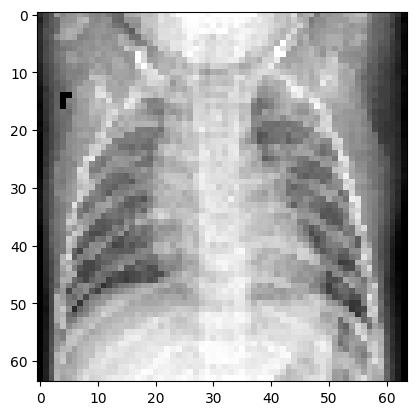

Label: 0.0


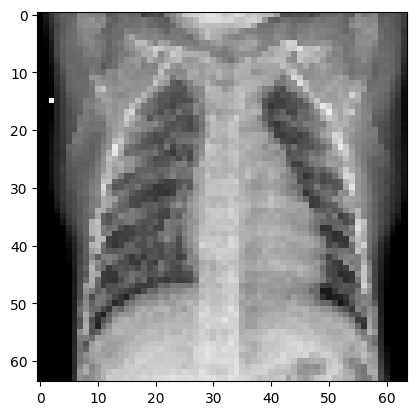

Label: 1.0


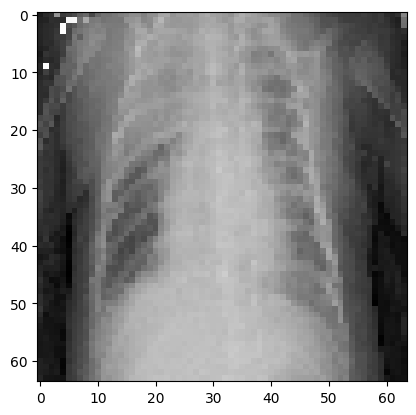

Label: 0.0


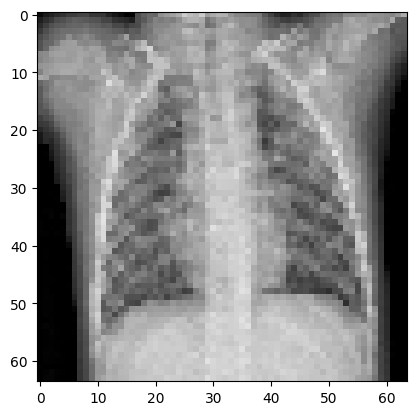

Label: 1.0


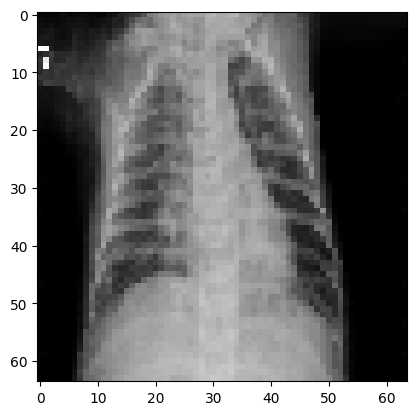

In [5]:
# Visualize a few sample images
sample_indices = [0, 1, 2, 3, 4]  # Adjust as needed
sample_images, sample_labels = get_train_data(flatten=False)
for i in sample_indices:
    plot_one_image(sample_images[i], labels=sample_labels[i])

In [6]:
# Define image shape
image_shape = (64, 64, 3)
# Data Preparation
X_train, y_train = get_train_data(flatten=False)
X_val, y_val = get_test_data(flatten=False)



In [7]:
# Data Augmentation (Optional)
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
def DenseClassifier(hidden_layer_sizes, nn_params, dropout=0):
    model = Sequential()
    model.add(Flatten(input_shape=nn_params['input_shape']))
    for ilayer in hidden_layer_sizes:
        model.add(Dense(ilayer, activation='relu'))
        if dropout:
            model.add(Dropout(dropout))
    model.add(Dense(units=nn_params['output_neurons'], activation=nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model


# Model Building

In [9]:
# Model Building - Toy Neural Network
toy_nn = DenseClassifier(hidden_layer_sizes=[128, 64], nn_params=nn_params, dropout=0.3)
print(model_to_string(toy_nn))  # Print the model summary
nn_params['input_shape'] = (64, 64, 3)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 128)               1572992   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,581,313
Trainable params: 1,581,313
Non-traina

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
history_toy_nn = toy_nn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
63/63 [==============================] - 5s 31ms/step - loss: 0.6587 - accuracy: 0.5975 - val_loss: 0.5975 - val_accuracy: 0.7700
Epoch 2/10
63/63 [==============================] - 2s 26ms/step - loss: 0.5684 - accuracy: 0.7210 - val_loss: 0.5313 - val_accuracy: 0.7775
Epoch 3/10
63/63 [==============================] - 2s 26ms/step - loss: 0.4893 - accuracy: 0.8060 - val_loss: 0.4799 - val_accuracy: 0.8250
Epoch 4/10
63/63 [==============================] - 2s 32ms/step - loss: 0.4439 - accuracy: 0.8255 - val_loss: 0.4541 - val_accuracy: 0.8275
Epoch 5/10
63/63 [==============================] - 2s 34ms/step - loss: 0.3904 - accuracy: 0.8480 - val_loss: 0.4382 - val_accuracy: 0.8050
Epoch 6/10
63/63 [==============================] - 1s 22ms/step - loss: 0.3742 - accuracy: 0.8595 - val_loss: 0.4085 - val_accuracy: 0.8325
Epoch 7/10
63/63 [==============================] - 2s 24ms/step - loss: 0.3293 - accuracy: 0.8795 - val_loss: 0.3896 - val_accuracy: 0.8375
Epoch 8/10
63

# Model Evalution

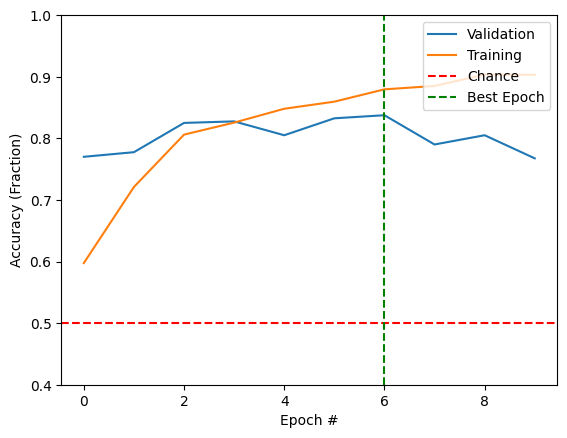

In [11]:
# Model Evaluation - Toy Neural Network
plot_acc(history_toy_nn)

In [12]:
import tensorflow as tf
import tensorflow as tf  # Make sure to import TensorFlow

# ...

def CNNClassifier(num_hidden_layers, nn_params, dropout=1):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers - 1):
        model.add(Conv2D(32, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units=128, activation='relu'))
    if dropout:
        model.add(Dropout(dropout))

    model.add(Dense(units=64, activation='relu'))

    model.add(Dense(units=nn_params['output_neurons'], activation=nn_params['output_activation']))

    # Use legacy RMSprop optimizer
    opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-4, decay=1e-6)

    model.compile(loss=nn_params['loss'], optimizer=opt, metrics=['accuracy'])
    return model


In [13]:
cnn_model = CNNClassifier(num_hidden_layers=3, nn_params=nn_params, dropout=0.3)
print(model_to_string(cnn_model))  # Print the model summary


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                          

# Model Training

In [14]:
# Model Training - CNN
history_cnn = cnn_model.fit(X_train.reshape(-1, *image_shape), y_train, epochs=10, batch_size=32,
                            validation_data=(X_val.reshape(-1, *image_shape), y_val), callbacks=[monitor])


Epoch 1/10


 1/63 [..............................] - ETA: 4:04 - loss: 0.6983 - accuracy: 0.4062

 2/63 [..............................] - ETA: 19s - loss: 0.6959 - accuracy: 0.4844 

 3/63 [>.............................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5104

 4/63 [>.............................] - ETA: 21s - loss: 0.7008 - accuracy: 0.4688

 5/63 [=>............................] - ETA: 22s - loss: 0.6984 - accuracy: 0.5000

 6/63 [=>............................] - ETA: 21s - loss: 0.6984 - accuracy: 0.4948

 7/63 [==>...........................] - ETA: 21s - loss: 0.6966 - accuracy: 0.5134

 8/63 [==>...........................] - ETA: 21s - loss: 0.6954 - accuracy: 0.5195

 9/63 [===>..........................] - ETA: 20s - loss: 0.6940 - accuracy: 0.5312

10/63 [===>..........................] - ETA: 21s - loss: 0.6931 - accuracy: 0.5406

11/63 [====>.........................] - ETA: 21s - loss: 0.6923 - accuracy: 0.5483

12/63 [====>.........................] - ETA: 20s - loss: 0.6905 - accuracy: 0.5625

13/63 [=====>........................] - ETA: 20s - loss: 0.6898 - accuracy: 0.5601

14/63 [=====>........................] - ETA: 19s - loss: 0.6907 - accuracy: 0.5491

15/63 [======>.......................] - ETA: 18s - loss: 0.6897 - accuracy: 0.5521

16/63 [======>.......................] - ETA: 18s - loss: 0.6889 - accuracy: 0.5566

17/63 [=======>......................] - ETA: 17s - loss: 0.6880 - accuracy: 0.5643

18/63 [=======>......................] - ETA: 16s - loss: 0.6878 - accuracy: 0.5660

19/63 [========>.....................] - ETA: 16s - loss: 0.6881 - accuracy: 0.5576

20/63 [========>.....................] - ETA: 16s - loss: 0.6874 - accuracy: 0.5578

21/63 [=========>....................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5610

22/63 [=========>....................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5611

23/63 [=========>....................] - ETA: 14s - loss: 0.6872 - accuracy: 0.5584

24/63 [==========>...................] - ETA: 14s - loss: 0.6872 - accuracy: 0.5599

25/63 [==========>...................] - ETA: 13s - loss: 0.6870 - accuracy: 0.5625

26/63 [===========>..................] - ETA: 13s - loss: 0.6870 - accuracy: 0.5613

27/63 [===========>..................] - ETA: 12s - loss: 0.6865 - accuracy: 0.5660

28/63 [============>.................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5703

29/63 [============>.................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5754

30/63 [=============>................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5740

31/63 [=============>................] - ETA: 10s - loss: 0.6837 - accuracy: 0.5756

32/63 [==============>...............] - ETA: 10s - loss: 0.6823 - accuracy: 0.5771

33/63 [==============>...............] - ETA: 9s - loss: 0.6808 - accuracy: 0.5795 

34/63 [===============>..............] - ETA: 9s - loss: 0.6816 - accuracy: 0.5772

35/63 [===============>..............] - ETA: 9s - loss: 0.6823 - accuracy: 0.5723

36/63 [================>.............] - ETA: 8s - loss: 0.6821 - accuracy: 0.5712

37/63 [================>.............] - ETA: 8s - loss: 0.6814 - accuracy: 0.5752

38/63 [=================>............] - ETA: 8s - loss: 0.6810 - accuracy: 0.5773

39/63 [=================>............] - ETA: 7s - loss: 0.6808 - accuracy: 0.5761

40/63 [==================>...........] - ETA: 7s - loss: 0.6804 - accuracy: 0.5766

41/63 [==================>...........] - ETA: 7s - loss: 0.6803 - accuracy: 0.5755

42/63 [===================>..........] - ETA: 6s - loss: 0.6799 - accuracy: 0.5766

43/63 [===================>..........] - ETA: 6s - loss: 0.6796 - accuracy: 0.5807

44/63 [===================>..........] - ETA: 5s - loss: 0.6794 - accuracy: 0.5838

45/63 [====================>.........] - ETA: 5s - loss: 0.6793 - accuracy: 0.5847

46/63 [====================>.........] - ETA: 5s - loss: 0.6787 - accuracy: 0.5897

47/63 [=====================>........] - ETA: 4s - loss: 0.6787 - accuracy: 0.5918

48/63 [=====================>........] - ETA: 4s - loss: 0.6788 - accuracy: 0.5885

49/63 [======================>.......] - ETA: 4s - loss: 0.6783 - accuracy: 0.5925

50/63 [======================>.......] - ETA: 3s - loss: 0.6779 - accuracy: 0.5938

51/63 [=======================>......] - ETA: 3s - loss: 0.6775 - accuracy: 0.5938

52/63 [=======================>......] - ETA: 3s - loss: 0.6772 - accuracy: 0.5956

53/63 [========================>.....] - ETA: 2s - loss: 0.6762 - accuracy: 0.6020

54/63 [========================>.....] - ETA: 2s - loss: 0.6759 - accuracy: 0.6036

55/63 [=========================>....] - ETA: 2s - loss: 0.6754 - accuracy: 0.6068

56/63 [=========================>....] - ETA: 2s - loss: 0.6748 - accuracy: 0.6099

57/63 [==========================>...] - ETA: 1s - loss: 0.6738 - accuracy: 0.6135

58/63 [==========================>...] - ETA: 1s - loss: 0.6730 - accuracy: 0.6164

59/63 [===========================>..] - ETA: 1s - loss: 0.6723 - accuracy: 0.6171

60/63 [===========================>..] - ETA: 0s - loss: 0.6715 - accuracy: 0.6182

61/63 [============================>.] - ETA: 0s - loss: 0.6713 - accuracy: 0.6178

62/63 [============================>.] - ETA: 0s - loss: 0.6708 - accuracy: 0.6184

63/63 [==============================] - 22s 289ms/step - loss: 0.6698 - accuracy: 0.6200 - val_loss: 0.6503 - val_accuracy: 0.5000
Epoch 2/10


 1/63 [..............................] - ETA: 13s - loss: 0.5941 - accuracy: 0.6250

 2/63 [..............................] - ETA: 11s - loss: 0.6474 - accuracy: 0.5156

 3/63 [>.............................] - ETA: 10s - loss: 0.6535 - accuracy: 0.5521

 4/63 [>.............................] - ETA: 10s - loss: 0.6494 - accuracy: 0.5781

 5/63 [=>............................] - ETA: 10s - loss: 0.6456 - accuracy: 0.6313

 6/63 [=>............................] - ETA: 10s - loss: 0.6420 - accuracy: 0.6406

 7/63 [==>...........................] - ETA: 10s - loss: 0.6382 - accuracy: 0.6607

 8/63 [==>...........................] - ETA: 10s - loss: 0.6387 - accuracy: 0.6641

 9/63 [===>..........................] - ETA: 9s - loss: 0.6375 - accuracy: 0.6771 

10/63 [===>..........................] - ETA: 9s - loss: 0.6408 - accuracy: 0.6719

11/63 [====>.........................] - ETA: 9s - loss: 0.6379 - accuracy: 0.6875

12/63 [====>.........................] - ETA: 9s - loss: 0.6386 - accuracy: 0.6797

13/63 [=====>........................] - ETA: 9s - loss: 0.6364 - accuracy: 0.6947

14/63 [=====>........................] - ETA: 9s - loss: 0.6367 - accuracy: 0.6987

15/63 [======>.......................] - ETA: 8s - loss: 0.6353 - accuracy: 0.7063

16/63 [======>.......................] - ETA: 8s - loss: 0.6352 - accuracy: 0.7090

17/63 [=======>......................] - ETA: 8s - loss: 0.6338 - accuracy: 0.7114

18/63 [=======>......................] - ETA: 8s - loss: 0.6330 - accuracy: 0.7101

19/63 [========>.....................] - ETA: 8s - loss: 0.6314 - accuracy: 0.7171

20/63 [========>.....................] - ETA: 8s - loss: 0.6295 - accuracy: 0.7266

21/63 [=========>....................] - ETA: 7s - loss: 0.6275 - accuracy: 0.7321

22/63 [=========>....................] - ETA: 7s - loss: 0.6270 - accuracy: 0.7330

23/63 [=========>....................] - ETA: 7s - loss: 0.6260 - accuracy: 0.7323

24/63 [==========>...................] - ETA: 7s - loss: 0.6265 - accuracy: 0.7305

25/63 [==========>...................] - ETA: 7s - loss: 0.6273 - accuracy: 0.7250

26/63 [===========>..................] - ETA: 6s - loss: 0.6268 - accuracy: 0.7272

27/63 [===========>..................] - ETA: 6s - loss: 0.6246 - accuracy: 0.7326

28/63 [============>.................] - ETA: 6s - loss: 0.6249 - accuracy: 0.7277

29/63 [============>.................] - ETA: 6s - loss: 0.6224 - accuracy: 0.7338

30/63 [=============>................] - ETA: 6s - loss: 0.6206 - accuracy: 0.7354

31/63 [=============>................] - ETA: 6s - loss: 0.6196 - accuracy: 0.7389

32/63 [==============>...............] - ETA: 6s - loss: 0.6182 - accuracy: 0.7432

33/63 [==============>...............] - ETA: 6s - loss: 0.6204 - accuracy: 0.7358

34/63 [===============>..............] - ETA: 6s - loss: 0.6198 - accuracy: 0.7335

35/63 [===============>..............] - ETA: 6s - loss: 0.6190 - accuracy: 0.7348

36/63 [================>.............] - ETA: 6s - loss: 0.6192 - accuracy: 0.7344

37/63 [================>.............] - ETA: 5s - loss: 0.6181 - accuracy: 0.7365

38/63 [=================>............] - ETA: 5s - loss: 0.6160 - accuracy: 0.7385

39/63 [=================>............] - ETA: 5s - loss: 0.6169 - accuracy: 0.7340

40/63 [==================>...........] - ETA: 5s - loss: 0.6158 - accuracy: 0.7367

41/63 [==================>...........] - ETA: 4s - loss: 0.6155 - accuracy: 0.7363

42/63 [===================>..........] - ETA: 4s - loss: 0.6130 - accuracy: 0.7418

43/63 [===================>..........] - ETA: 4s - loss: 0.6136 - accuracy: 0.7355

44/63 [===================>..........] - ETA: 4s - loss: 0.6124 - accuracy: 0.7372

45/63 [====================>.........] - ETA: 3s - loss: 0.6116 - accuracy: 0.7340

46/63 [====================>.........] - ETA: 3s - loss: 0.6110 - accuracy: 0.7357

47/63 [=====================>........] - ETA: 3s - loss: 0.6099 - accuracy: 0.7380

48/63 [=====================>........] - ETA: 3s - loss: 0.6088 - accuracy: 0.7389

49/63 [======================>.......] - ETA: 3s - loss: 0.6070 - accuracy: 0.7430

50/63 [======================>.......] - ETA: 2s - loss: 0.6053 - accuracy: 0.7444

51/63 [=======================>......] - ETA: 2s - loss: 0.6040 - accuracy: 0.7463

52/63 [=======================>......] - ETA: 2s - loss: 0.6027 - accuracy: 0.7470

53/63 [========================>.....] - ETA: 2s - loss: 0.6009 - accuracy: 0.7506

54/63 [========================>.....] - ETA: 1s - loss: 0.6004 - accuracy: 0.7506

55/63 [=========================>....] - ETA: 1s - loss: 0.5986 - accuracy: 0.7528

56/63 [=========================>....] - ETA: 1s - loss: 0.5982 - accuracy: 0.7528

57/63 [==========================>...] - ETA: 1s - loss: 0.5971 - accuracy: 0.7538

58/63 [==========================>...] - ETA: 1s - loss: 0.5952 - accuracy: 0.7570

59/63 [===========================>..] - ETA: 0s - loss: 0.5937 - accuracy: 0.7579

60/63 [===========================>..] - ETA: 0s - loss: 0.5921 - accuracy: 0.7594

61/63 [============================>.] - ETA: 0s - loss: 0.5923 - accuracy: 0.7556

62/63 [============================>.] - ETA: 0s - loss: 0.5915 - accuracy: 0.7550

63/63 [==============================] - 14s 218ms/step - loss: 0.5907 - accuracy: 0.7555 - val_loss: 0.5322 - val_accuracy: 0.8375
Epoch 3/10


 1/63 [..............................] - ETA: 11s - loss: 0.4544 - accuracy: 0.9062

 2/63 [..............................] - ETA: 10s - loss: 0.4886 - accuracy: 0.8594

 3/63 [>.............................] - ETA: 10s - loss: 0.4987 - accuracy: 0.8646

 4/63 [>.............................] - ETA: 10s - loss: 0.5177 - accuracy: 0.8203

 5/63 [=>............................] - ETA: 10s - loss: 0.5158 - accuracy: 0.8313

 6/63 [=>............................] - ETA: 10s - loss: 0.5183 - accuracy: 0.8177

 7/63 [==>...........................] - ETA: 10s - loss: 0.5172 - accuracy: 0.8259

 8/63 [==>...........................] - ETA: 10s - loss: 0.5090 - accuracy: 0.8320

 9/63 [===>..........................] - ETA: 10s - loss: 0.5060 - accuracy: 0.8368

10/63 [===>..........................] - ETA: 10s - loss: 0.5063 - accuracy: 0.8375

11/63 [====>.........................] - ETA: 9s - loss: 0.5106 - accuracy: 0.8239 

12/63 [====>.........................] - ETA: 9s - loss: 0.5103 - accuracy: 0.8229

13/63 [=====>........................] - ETA: 9s - loss: 0.5111 - accuracy: 0.8221

14/63 [=====>........................] - ETA: 9s - loss: 0.5084 - accuracy: 0.8304

15/63 [======>.......................] - ETA: 9s - loss: 0.5071 - accuracy: 0.8292

16/63 [======>.......................] - ETA: 8s - loss: 0.5140 - accuracy: 0.8164

17/63 [=======>......................] - ETA: 8s - loss: 0.5114 - accuracy: 0.8180

18/63 [=======>......................] - ETA: 8s - loss: 0.5087 - accuracy: 0.8229

19/63 [========>.....................] - ETA: 8s - loss: 0.5105 - accuracy: 0.8207

20/63 [========>.....................] - ETA: 8s - loss: 0.5083 - accuracy: 0.8234

21/63 [=========>....................] - ETA: 7s - loss: 0.5094 - accuracy: 0.8199

22/63 [=========>....................] - ETA: 7s - loss: 0.5076 - accuracy: 0.8210

23/63 [=========>....................] - ETA: 7s - loss: 0.5065 - accuracy: 0.8234

24/63 [==========>...................] - ETA: 7s - loss: 0.5062 - accuracy: 0.8268

25/63 [==========>...................] - ETA: 7s - loss: 0.5070 - accuracy: 0.8250

26/63 [===========>..................] - ETA: 7s - loss: 0.5037 - accuracy: 0.8269

27/63 [===========>..................] - ETA: 7s - loss: 0.5010 - accuracy: 0.8287

28/63 [============>.................] - ETA: 7s - loss: 0.5003 - accuracy: 0.8270

29/63 [============>.................] - ETA: 7s - loss: 0.4978 - accuracy: 0.8287

30/63 [=============>................] - ETA: 7s - loss: 0.4921 - accuracy: 0.8323

31/63 [=============>................] - ETA: 7s - loss: 0.4921 - accuracy: 0.8317

32/63 [==============>...............] - ETA: 7s - loss: 0.4924 - accuracy: 0.8311

33/63 [==============>...............] - ETA: 7s - loss: 0.4947 - accuracy: 0.8305

34/63 [===============>..............] - ETA: 6s - loss: 0.4944 - accuracy: 0.8263

35/63 [===============>..............] - ETA: 6s - loss: 0.4934 - accuracy: 0.8286

36/63 [================>.............] - ETA: 6s - loss: 0.4924 - accuracy: 0.8281

37/63 [================>.............] - ETA: 5s - loss: 0.4937 - accuracy: 0.8269

38/63 [=================>............] - ETA: 5s - loss: 0.4956 - accuracy: 0.8224

39/63 [=================>............] - ETA: 5s - loss: 0.4950 - accuracy: 0.8237

40/63 [==================>...........] - ETA: 5s - loss: 0.4935 - accuracy: 0.8258

41/63 [==================>...........] - ETA: 4s - loss: 0.4921 - accuracy: 0.8262

42/63 [===================>..........] - ETA: 4s - loss: 0.4902 - accuracy: 0.8274

43/63 [===================>..........] - ETA: 4s - loss: 0.4888 - accuracy: 0.8285

44/63 [===================>..........] - ETA: 4s - loss: 0.4878 - accuracy: 0.8295

45/63 [====================>.........] - ETA: 3s - loss: 0.4878 - accuracy: 0.8292

46/63 [====================>.........] - ETA: 3s - loss: 0.4857 - accuracy: 0.8302

47/63 [=====================>........] - ETA: 3s - loss: 0.4842 - accuracy: 0.8311

48/63 [=====================>........] - ETA: 3s - loss: 0.4817 - accuracy: 0.8340

49/63 [======================>.......] - ETA: 3s - loss: 0.4794 - accuracy: 0.8355

50/63 [======================>.......] - ETA: 2s - loss: 0.4775 - accuracy: 0.8369

51/63 [=======================>......] - ETA: 2s - loss: 0.4753 - accuracy: 0.8376

52/63 [=======================>......] - ETA: 2s - loss: 0.4747 - accuracy: 0.8395

53/63 [========================>.....] - ETA: 2s - loss: 0.4726 - accuracy: 0.8414

54/63 [========================>.....] - ETA: 1s - loss: 0.4710 - accuracy: 0.8409

55/63 [=========================>....] - ETA: 1s - loss: 0.4713 - accuracy: 0.8409

56/63 [=========================>....] - ETA: 1s - loss: 0.4698 - accuracy: 0.8426

57/63 [==========================>...] - ETA: 1s - loss: 0.4684 - accuracy: 0.8438

58/63 [==========================>...] - ETA: 1s - loss: 0.4676 - accuracy: 0.8438

59/63 [===========================>..] - ETA: 0s - loss: 0.4667 - accuracy: 0.8438

60/63 [===========================>..] - ETA: 0s - loss: 0.4655 - accuracy: 0.8438

61/63 [============================>.] - ETA: 0s - loss: 0.4632 - accuracy: 0.8453

62/63 [============================>.] - ETA: 0s - loss: 0.4626 - accuracy: 0.8448

63/63 [==============================] - 14s 221ms/step - loss: 0.4623 - accuracy: 0.8445 - val_loss: 0.4253 - val_accuracy: 0.8375
Epoch 4/10


 1/63 [..............................] - ETA: 11s - loss: 0.3889 - accuracy: 0.8438

 2/63 [..............................] - ETA: 11s - loss: 0.4156 - accuracy: 0.8125

 3/63 [>.............................] - ETA: 11s - loss: 0.4041 - accuracy: 0.8229

 4/63 [>.............................] - ETA: 11s - loss: 0.4409 - accuracy: 0.7969

 5/63 [=>............................] - ETA: 10s - loss: 0.4489 - accuracy: 0.7812

 6/63 [=>............................] - ETA: 10s - loss: 0.4296 - accuracy: 0.8021

 7/63 [==>...........................] - ETA: 10s - loss: 0.4154 - accuracy: 0.8214

 8/63 [==>...........................] - ETA: 10s - loss: 0.4045 - accuracy: 0.8359

 9/63 [===>..........................] - ETA: 10s - loss: 0.3936 - accuracy: 0.8438

10/63 [===>..........................] - ETA: 10s - loss: 0.3900 - accuracy: 0.8438

11/63 [====>.........................] - ETA: 9s - loss: 0.3855 - accuracy: 0.8523 

12/63 [====>.........................] - ETA: 9s - loss: 0.3901 - accuracy: 0.8464

13/63 [=====>........................] - ETA: 9s - loss: 0.3985 - accuracy: 0.8389

14/63 [=====>........................] - ETA: 9s - loss: 0.3974 - accuracy: 0.8393

15/63 [======>.......................] - ETA: 9s - loss: 0.3993 - accuracy: 0.8375

16/63 [======>.......................] - ETA: 8s - loss: 0.3959 - accuracy: 0.8398

17/63 [=======>......................] - ETA: 8s - loss: 0.3902 - accuracy: 0.8438

18/63 [=======>......................] - ETA: 8s - loss: 0.3856 - accuracy: 0.8524

19/63 [========>.....................] - ETA: 8s - loss: 0.3821 - accuracy: 0.8586

20/63 [========>.....................] - ETA: 8s - loss: 0.3835 - accuracy: 0.8562

21/63 [=========>....................] - ETA: 8s - loss: 0.3837 - accuracy: 0.8527

22/63 [=========>....................] - ETA: 8s - loss: 0.3838 - accuracy: 0.8537

23/63 [=========>....................] - ETA: 8s - loss: 0.3874 - accuracy: 0.8505

24/63 [==========>...................] - ETA: 8s - loss: 0.3949 - accuracy: 0.8477

25/63 [==========>...................] - ETA: 8s - loss: 0.3945 - accuracy: 0.8512

26/63 [===========>..................] - ETA: 8s - loss: 0.3922 - accuracy: 0.8534

27/63 [===========>..................] - ETA: 8s - loss: 0.3916 - accuracy: 0.8530

28/63 [============>.................] - ETA: 8s - loss: 0.3892 - accuracy: 0.8549

29/63 [============>.................] - ETA: 8s - loss: 0.3902 - accuracy: 0.8524

30/63 [=============>................] - ETA: 7s - loss: 0.3878 - accuracy: 0.8531

31/63 [=============>................] - ETA: 7s - loss: 0.3839 - accuracy: 0.8558

32/63 [==============>...............] - ETA: 7s - loss: 0.3851 - accuracy: 0.8535

33/63 [==============>...............] - ETA: 7s - loss: 0.3867 - accuracy: 0.8532

34/63 [===============>..............] - ETA: 6s - loss: 0.3867 - accuracy: 0.8520

35/63 [===============>..............] - ETA: 6s - loss: 0.3852 - accuracy: 0.8527

36/63 [================>.............] - ETA: 6s - loss: 0.3850 - accuracy: 0.8524

37/63 [================>.............] - ETA: 6s - loss: 0.3846 - accuracy: 0.8530

38/63 [=================>............] - ETA: 5s - loss: 0.3818 - accuracy: 0.8544

39/63 [=================>............] - ETA: 5s - loss: 0.3795 - accuracy: 0.8566

40/63 [==================>...........] - ETA: 5s - loss: 0.3770 - accuracy: 0.8586

41/63 [==================>...........] - ETA: 5s - loss: 0.3769 - accuracy: 0.8605

42/63 [===================>..........] - ETA: 4s - loss: 0.3747 - accuracy: 0.8624

43/63 [===================>..........] - ETA: 4s - loss: 0.3735 - accuracy: 0.8641

44/63 [===================>..........] - ETA: 4s - loss: 0.3709 - accuracy: 0.8658

45/63 [====================>.........] - ETA: 4s - loss: 0.3762 - accuracy: 0.8618

46/63 [====================>.........] - ETA: 3s - loss: 0.3788 - accuracy: 0.8594

47/63 [=====================>........] - ETA: 3s - loss: 0.3796 - accuracy: 0.8604

48/63 [=====================>........] - ETA: 3s - loss: 0.3804 - accuracy: 0.8594

49/63 [======================>.......] - ETA: 3s - loss: 0.3785 - accuracy: 0.8610

50/63 [======================>.......] - ETA: 2s - loss: 0.3793 - accuracy: 0.8606

51/63 [=======================>......] - ETA: 2s - loss: 0.3798 - accuracy: 0.8603

52/63 [=======================>......] - ETA: 2s - loss: 0.3803 - accuracy: 0.8594

53/63 [========================>.....] - ETA: 2s - loss: 0.3788 - accuracy: 0.8603

54/63 [========================>.....] - ETA: 1s - loss: 0.3779 - accuracy: 0.8611

55/63 [=========================>....] - ETA: 1s - loss: 0.3778 - accuracy: 0.8608

56/63 [=========================>....] - ETA: 1s - loss: 0.3765 - accuracy: 0.8599

57/63 [==========================>...] - ETA: 1s - loss: 0.3742 - accuracy: 0.8613

58/63 [==========================>...] - ETA: 1s - loss: 0.3739 - accuracy: 0.8615

59/63 [===========================>..] - ETA: 0s - loss: 0.3733 - accuracy: 0.8612

60/63 [===========================>..] - ETA: 0s - loss: 0.3716 - accuracy: 0.8630

61/63 [============================>.] - ETA: 0s - loss: 0.3696 - accuracy: 0.8642

62/63 [============================>.] - ETA: 0s - loss: 0.3675 - accuracy: 0.8649

63/63 [==============================] - 14s 225ms/step - loss: 0.3666 - accuracy: 0.8650 - val_loss: 0.6473 - val_accuracy: 0.6275
Epoch 5/10


 1/63 [..............................] - ETA: 11s - loss: 0.4736 - accuracy: 0.7188

 2/63 [..............................] - ETA: 11s - loss: 0.4344 - accuracy: 0.7812

 3/63 [>.............................] - ETA: 11s - loss: 0.4046 - accuracy: 0.8125

 4/63 [>.............................] - ETA: 11s - loss: 0.3884 - accuracy: 0.8438

 5/63 [=>............................] - ETA: 10s - loss: 0.3674 - accuracy: 0.8562

 6/63 [=>............................] - ETA: 10s - loss: 0.3557 - accuracy: 0.8698

 7/63 [==>...........................] - ETA: 10s - loss: 0.3526 - accuracy: 0.8795

 8/63 [==>...........................] - ETA: 10s - loss: 0.3559 - accuracy: 0.8711

 9/63 [===>..........................] - ETA: 10s - loss: 0.3555 - accuracy: 0.8715

10/63 [===>..........................] - ETA: 9s - loss: 0.3612 - accuracy: 0.8594 

11/63 [====>.........................] - ETA: 9s - loss: 0.3696 - accuracy: 0.8494

12/63 [====>.........................] - ETA: 9s - loss: 0.3622 - accuracy: 0.8516

13/63 [=====>........................] - ETA: 9s - loss: 0.3490 - accuracy: 0.8630

14/63 [=====>........................] - ETA: 9s - loss: 0.3482 - accuracy: 0.8661

15/63 [======>.......................] - ETA: 9s - loss: 0.3424 - accuracy: 0.8687

16/63 [======>.......................] - ETA: 9s - loss: 0.3355 - accuracy: 0.8730

17/63 [=======>......................] - ETA: 9s - loss: 0.3341 - accuracy: 0.8750

18/63 [=======>......................] - ETA: 9s - loss: 0.3419 - accuracy: 0.8715

19/63 [========>.....................] - ETA: 9s - loss: 0.3420 - accuracy: 0.8717

20/63 [========>.....................] - ETA: 9s - loss: 0.3384 - accuracy: 0.8750

21/63 [=========>....................] - ETA: 9s - loss: 0.3373 - accuracy: 0.8765

22/63 [=========>....................] - ETA: 9s - loss: 0.3374 - accuracy: 0.8750

23/63 [=========>....................] - ETA: 9s - loss: 0.3394 - accuracy: 0.8750

24/63 [==========>...................] - ETA: 9s - loss: 0.3419 - accuracy: 0.8724

25/63 [==========>...................] - ETA: 9s - loss: 0.3412 - accuracy: 0.8725

26/63 [===========>..................] - ETA: 9s - loss: 0.3407 - accuracy: 0.8726

27/63 [===========>..................] - ETA: 8s - loss: 0.3396 - accuracy: 0.8727

28/63 [============>.................] - ETA: 8s - loss: 0.3356 - accuracy: 0.8739

29/63 [============>.................] - ETA: 8s - loss: 0.3330 - accuracy: 0.8761

30/63 [=============>................] - ETA: 7s - loss: 0.3311 - accuracy: 0.8771

31/63 [=============>................] - ETA: 7s - loss: 0.3309 - accuracy: 0.8770

32/63 [==============>...............] - ETA: 7s - loss: 0.3318 - accuracy: 0.8750

33/63 [==============>...............] - ETA: 7s - loss: 0.3304 - accuracy: 0.8750

34/63 [===============>..............] - ETA: 6s - loss: 0.3273 - accuracy: 0.8778

35/63 [===============>..............] - ETA: 6s - loss: 0.3242 - accuracy: 0.8804

36/63 [================>.............] - ETA: 6s - loss: 0.3228 - accuracy: 0.8819

37/63 [================>.............] - ETA: 5s - loss: 0.3220 - accuracy: 0.8818

38/63 [=================>............] - ETA: 5s - loss: 0.3274 - accuracy: 0.8783

39/63 [=================>............] - ETA: 5s - loss: 0.3290 - accuracy: 0.8766

40/63 [==================>...........] - ETA: 5s - loss: 0.3261 - accuracy: 0.8797

41/63 [==================>...........] - ETA: 4s - loss: 0.3246 - accuracy: 0.8811

42/63 [===================>..........] - ETA: 4s - loss: 0.3255 - accuracy: 0.8810

43/63 [===================>..........] - ETA: 4s - loss: 0.3245 - accuracy: 0.8808

44/63 [===================>..........] - ETA: 4s - loss: 0.3236 - accuracy: 0.8821

45/63 [====================>.........] - ETA: 4s - loss: 0.3222 - accuracy: 0.8826

46/63 [====================>.........] - ETA: 3s - loss: 0.3208 - accuracy: 0.8832

47/63 [=====================>........] - ETA: 3s - loss: 0.3241 - accuracy: 0.8803

48/63 [=====================>........] - ETA: 3s - loss: 0.3232 - accuracy: 0.8815

49/63 [======================>.......] - ETA: 3s - loss: 0.3221 - accuracy: 0.8827

50/63 [======================>.......] - ETA: 2s - loss: 0.3216 - accuracy: 0.8838

51/63 [=======================>......] - ETA: 2s - loss: 0.3208 - accuracy: 0.8842

52/63 [=======================>......] - ETA: 2s - loss: 0.3281 - accuracy: 0.8798

53/63 [========================>.....] - ETA: 2s - loss: 0.3273 - accuracy: 0.8809

54/63 [========================>.....] - ETA: 1s - loss: 0.3246 - accuracy: 0.8825

55/63 [=========================>....] - ETA: 1s - loss: 0.3233 - accuracy: 0.8835

56/63 [=========================>....] - ETA: 1s - loss: 0.3237 - accuracy: 0.8839

57/63 [==========================>...] - ETA: 1s - loss: 0.3230 - accuracy: 0.8838

58/63 [==========================>...] - ETA: 1s - loss: 0.3215 - accuracy: 0.8852

59/63 [===========================>..] - ETA: 0s - loss: 0.3220 - accuracy: 0.8840

60/63 [===========================>..] - ETA: 0s - loss: 0.3212 - accuracy: 0.8849

61/63 [============================>.] - ETA: 0s - loss: 0.3240 - accuracy: 0.8822

62/63 [============================>.] - ETA: 0s - loss: 0.3221 - accuracy: 0.8841

63/63 [==============================] - 14s 225ms/step - loss: 0.3220 - accuracy: 0.8845 - val_loss: 0.4067 - val_accuracy: 0.8225
Epoch 6/10


 1/63 [..............................] - ETA: 11s - loss: 0.2259 - accuracy: 0.9688

 2/63 [..............................] - ETA: 12s - loss: 0.2655 - accuracy: 0.8906

 3/63 [>.............................] - ETA: 11s - loss: 0.2623 - accuracy: 0.9062

 4/63 [>.............................] - ETA: 11s - loss: 0.2888 - accuracy: 0.8828

 5/63 [=>............................] - ETA: 11s - loss: 0.2825 - accuracy: 0.9000

 6/63 [=>............................] - ETA: 11s - loss: 0.2967 - accuracy: 0.8958

 7/63 [==>...........................] - ETA: 10s - loss: 0.2954 - accuracy: 0.8973

 8/63 [==>...........................] - ETA: 10s - loss: 0.2930 - accuracy: 0.8984

 9/63 [===>..........................] - ETA: 10s - loss: 0.2852 - accuracy: 0.9028

10/63 [===>..........................] - ETA: 10s - loss: 0.2812 - accuracy: 0.9000

11/63 [====>.........................] - ETA: 10s - loss: 0.2771 - accuracy: 0.9006

12/63 [====>.........................] - ETA: 10s - loss: 0.2806 - accuracy: 0.9010

13/63 [=====>........................] - ETA: 11s - loss: 0.2765 - accuracy: 0.9038

14/63 [=====>........................] - ETA: 11s - loss: 0.2812 - accuracy: 0.9018

15/63 [======>.......................] - ETA: 11s - loss: 0.2884 - accuracy: 0.8979

16/63 [======>.......................] - ETA: 11s - loss: 0.2985 - accuracy: 0.8906

17/63 [=======>......................] - ETA: 11s - loss: 0.2992 - accuracy: 0.8897

18/63 [=======>......................] - ETA: 11s - loss: 0.2972 - accuracy: 0.8872

19/63 [========>.....................] - ETA: 11s - loss: 0.2938 - accuracy: 0.8882

20/63 [========>.....................] - ETA: 11s - loss: 0.2922 - accuracy: 0.8891

21/63 [=========>....................] - ETA: 11s - loss: 0.2912 - accuracy: 0.8899

22/63 [=========>....................] - ETA: 10s - loss: 0.2836 - accuracy: 0.8949

23/63 [=========>....................] - ETA: 10s - loss: 0.2816 - accuracy: 0.8954

24/63 [==========>...................] - ETA: 9s - loss: 0.2833 - accuracy: 0.8958 

25/63 [==========>...................] - ETA: 9s - loss: 0.2862 - accuracy: 0.8925

26/63 [===========>..................] - ETA: 9s - loss: 0.2880 - accuracy: 0.8894

27/63 [===========>..................] - ETA: 8s - loss: 0.2883 - accuracy: 0.8912

28/63 [============>.................] - ETA: 8s - loss: 0.2840 - accuracy: 0.8940

29/63 [============>.................] - ETA: 8s - loss: 0.2790 - accuracy: 0.8966

30/63 [=============>................] - ETA: 8s - loss: 0.2778 - accuracy: 0.8958

31/63 [=============>................] - ETA: 7s - loss: 0.2762 - accuracy: 0.8962

32/63 [==============>...............] - ETA: 7s - loss: 0.2757 - accuracy: 0.8975

33/63 [==============>...............] - ETA: 7s - loss: 0.2764 - accuracy: 0.8968

34/63 [===============>..............] - ETA: 6s - loss: 0.2754 - accuracy: 0.8971

35/63 [===============>..............] - ETA: 6s - loss: 0.2732 - accuracy: 0.8973

36/63 [================>.............] - ETA: 6s - loss: 0.2747 - accuracy: 0.8967

37/63 [================>.............] - ETA: 6s - loss: 0.2743 - accuracy: 0.8961

38/63 [=================>............] - ETA: 5s - loss: 0.2735 - accuracy: 0.8964

39/63 [=================>............] - ETA: 5s - loss: 0.2718 - accuracy: 0.8974

40/63 [==================>...........] - ETA: 5s - loss: 0.2691 - accuracy: 0.8992

41/63 [==================>...........] - ETA: 5s - loss: 0.2667 - accuracy: 0.9002

42/63 [===================>..........] - ETA: 4s - loss: 0.2666 - accuracy: 0.9003

43/63 [===================>..........] - ETA: 4s - loss: 0.2674 - accuracy: 0.8997

44/63 [===================>..........] - ETA: 4s - loss: 0.2689 - accuracy: 0.8977

45/63 [====================>.........] - ETA: 4s - loss: 0.2707 - accuracy: 0.8972

46/63 [====================>.........] - ETA: 3s - loss: 0.2763 - accuracy: 0.8954

47/63 [=====================>........] - ETA: 3s - loss: 0.2757 - accuracy: 0.8949

48/63 [=====================>........] - ETA: 3s - loss: 0.2760 - accuracy: 0.8945

49/63 [======================>.......] - ETA: 3s - loss: 0.2749 - accuracy: 0.8960

50/63 [======================>.......] - ETA: 2s - loss: 0.2722 - accuracy: 0.8975

51/63 [=======================>......] - ETA: 2s - loss: 0.2735 - accuracy: 0.8964

52/63 [=======================>......] - ETA: 2s - loss: 0.2745 - accuracy: 0.8948

53/63 [========================>.....] - ETA: 2s - loss: 0.2758 - accuracy: 0.8933

54/63 [========================>.....] - ETA: 1s - loss: 0.2790 - accuracy: 0.8924

55/63 [=========================>....] - ETA: 1s - loss: 0.2771 - accuracy: 0.8938

56/63 [=========================>....] - ETA: 1s - loss: 0.2794 - accuracy: 0.8929

57/63 [==========================>...] - ETA: 1s - loss: 0.2807 - accuracy: 0.8914

58/63 [==========================>...] - ETA: 1s - loss: 0.2832 - accuracy: 0.8885

59/63 [===========================>..] - ETA: 0s - loss: 0.2816 - accuracy: 0.8898

60/63 [===========================>..] - ETA: 0s - loss: 0.2801 - accuracy: 0.8911

61/63 [============================>.] - ETA: 0s - loss: 0.2780 - accuracy: 0.8924

62/63 [============================>.] - ETA: 0s - loss: 0.2785 - accuracy: 0.8926

63/63 [==============================] - 14s 227ms/step - loss: 0.2810 - accuracy: 0.8920 - val_loss: 0.4148 - val_accuracy: 0.8025
Epoch 7/10


 1/63 [..............................] - ETA: 11s - loss: 0.1078 - accuracy: 0.9688

 2/63 [..............................] - ETA: 11s - loss: 0.1493 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 12s - loss: 0.1768 - accuracy: 0.9583

 4/63 [>.............................] - ETA: 11s - loss: 0.1839 - accuracy: 0.9453

 5/63 [=>............................] - ETA: 11s - loss: 0.1811 - accuracy: 0.9500

 6/63 [=>............................] - ETA: 11s - loss: 0.1914 - accuracy: 0.9427

 7/63 [==>...........................] - ETA: 12s - loss: 0.2100 - accuracy: 0.9286

 8/63 [==>...........................] - ETA: 13s - loss: 0.2204 - accuracy: 0.9219

 9/63 [===>..........................] - ETA: 13s - loss: 0.2269 - accuracy: 0.9097

10/63 [===>..........................] - ETA: 13s - loss: 0.2230 - accuracy: 0.9125

11/63 [====>.........................] - ETA: 14s - loss: 0.2203 - accuracy: 0.9119

12/63 [====>.........................] - ETA: 14s - loss: 0.2214 - accuracy: 0.9089

13/63 [=====>........................] - ETA: 14s - loss: 0.2234 - accuracy: 0.9087

14/63 [=====>........................] - ETA: 14s - loss: 0.2296 - accuracy: 0.9040

15/63 [======>.......................] - ETA: 13s - loss: 0.2260 - accuracy: 0.9083

16/63 [======>.......................] - ETA: 13s - loss: 0.2316 - accuracy: 0.9062

17/63 [=======>......................] - ETA: 13s - loss: 0.2384 - accuracy: 0.9007

18/63 [=======>......................] - ETA: 12s - loss: 0.2469 - accuracy: 0.8924

19/63 [========>.....................] - ETA: 12s - loss: 0.2445 - accuracy: 0.8964

20/63 [========>.....................] - ETA: 11s - loss: 0.2416 - accuracy: 0.8969

21/63 [=========>....................] - ETA: 11s - loss: 0.2449 - accuracy: 0.8973

22/63 [=========>....................] - ETA: 10s - loss: 0.2434 - accuracy: 0.8977

23/63 [=========>....................] - ETA: 10s - loss: 0.2444 - accuracy: 0.8967

24/63 [==========>...................] - ETA: 10s - loss: 0.2476 - accuracy: 0.8984

25/63 [==========>...................] - ETA: 9s - loss: 0.2467 - accuracy: 0.8988 

26/63 [===========>..................] - ETA: 9s - loss: 0.2448 - accuracy: 0.9002

27/63 [===========>..................] - ETA: 9s - loss: 0.2451 - accuracy: 0.9005

28/63 [============>.................] - ETA: 8s - loss: 0.2407 - accuracy: 0.9029

29/63 [============>.................] - ETA: 8s - loss: 0.2382 - accuracy: 0.9041

30/63 [=============>................] - ETA: 8s - loss: 0.2376 - accuracy: 0.9052

31/63 [=============>................] - ETA: 7s - loss: 0.2376 - accuracy: 0.9052

32/63 [==============>...............] - ETA: 7s - loss: 0.2389 - accuracy: 0.9053

33/63 [==============>...............] - ETA: 7s - loss: 0.2379 - accuracy: 0.9053

34/63 [===============>..............] - ETA: 6s - loss: 0.2390 - accuracy: 0.9053

35/63 [===============>..............] - ETA: 6s - loss: 0.2363 - accuracy: 0.9071

36/63 [================>.............] - ETA: 6s - loss: 0.2370 - accuracy: 0.9080

37/63 [================>.............] - ETA: 6s - loss: 0.2336 - accuracy: 0.9105

38/63 [=================>............] - ETA: 5s - loss: 0.2334 - accuracy: 0.9112

39/63 [=================>............] - ETA: 5s - loss: 0.2347 - accuracy: 0.9087

40/63 [==================>...........] - ETA: 5s - loss: 0.2322 - accuracy: 0.9094

41/63 [==================>...........] - ETA: 5s - loss: 0.2325 - accuracy: 0.9085

42/63 [===================>..........] - ETA: 4s - loss: 0.2308 - accuracy: 0.9085

43/63 [===================>..........] - ETA: 4s - loss: 0.2309 - accuracy: 0.9084

44/63 [===================>..........] - ETA: 4s - loss: 0.2337 - accuracy: 0.9048

45/63 [====================>.........] - ETA: 4s - loss: 0.2357 - accuracy: 0.9042

46/63 [====================>.........] - ETA: 4s - loss: 0.2383 - accuracy: 0.9035

47/63 [=====================>........] - ETA: 3s - loss: 0.2395 - accuracy: 0.9023

48/63 [=====================>........] - ETA: 3s - loss: 0.2382 - accuracy: 0.9023

49/63 [======================>.......] - ETA: 3s - loss: 0.2416 - accuracy: 0.9011

50/63 [======================>.......] - ETA: 3s - loss: 0.2408 - accuracy: 0.9013

51/63 [=======================>......] - ETA: 2s - loss: 0.2387 - accuracy: 0.9026

52/63 [=======================>......] - ETA: 2s - loss: 0.2372 - accuracy: 0.9038

53/63 [========================>.....] - ETA: 2s - loss: 0.2352 - accuracy: 0.9051

54/63 [========================>.....] - ETA: 2s - loss: 0.2377 - accuracy: 0.9034

55/63 [=========================>....] - ETA: 1s - loss: 0.2348 - accuracy: 0.9051

56/63 [=========================>....] - ETA: 1s - loss: 0.2343 - accuracy: 0.9051

57/63 [==========================>...] - ETA: 1s - loss: 0.2324 - accuracy: 0.9062

58/63 [==========================>...] - ETA: 1s - loss: 0.2306 - accuracy: 0.9073

59/63 [===========================>..] - ETA: 0s - loss: 0.2305 - accuracy: 0.9073

60/63 [===========================>..] - ETA: 0s - loss: 0.2330 - accuracy: 0.9057

61/63 [============================>.] - ETA: 0s - loss: 0.2326 - accuracy: 0.9057

62/63 [============================>.] - ETA: 0s - loss: 0.2314 - accuracy: 0.9068

63/63 [==============================] - 16s 253ms/step - loss: 0.2336 - accuracy: 0.9050 - val_loss: 0.5984 - val_accuracy: 0.7300
Epoch 8/10


 1/63 [..............................] - ETA: 20s - loss: 0.8801 - accuracy: 0.6250

 2/63 [..............................] - ETA: 21s - loss: 0.6004 - accuracy: 0.7500

 3/63 [>.............................] - ETA: 20s - loss: 0.4726 - accuracy: 0.8021

 4/63 [>.............................] - ETA: 20s - loss: 0.4114 - accuracy: 0.8281

 5/63 [=>............................] - ETA: 19s - loss: 0.3608 - accuracy: 0.8562

 6/63 [=>............................] - ETA: 17s - loss: 0.3219 - accuracy: 0.8698

 7/63 [==>...........................] - ETA: 16s - loss: 0.2956 - accuracy: 0.8884

 8/63 [==>...........................] - ETA: 15s - loss: 0.2764 - accuracy: 0.8984

 9/63 [===>..........................] - ETA: 14s - loss: 0.2742 - accuracy: 0.8993

10/63 [===>..........................] - ETA: 14s - loss: 0.2687 - accuracy: 0.9031

11/63 [====>.........................] - ETA: 13s - loss: 0.2759 - accuracy: 0.8920

12/63 [====>.........................] - ETA: 12s - loss: 0.2633 - accuracy: 0.8984

13/63 [=====>........................] - ETA: 12s - loss: 0.2609 - accuracy: 0.8990

14/63 [=====>........................] - ETA: 13s - loss: 0.2603 - accuracy: 0.8973

15/63 [======>.......................] - ETA: 12s - loss: 0.2567 - accuracy: 0.8979

16/63 [======>.......................] - ETA: 12s - loss: 0.2485 - accuracy: 0.9023

17/63 [=======>......................] - ETA: 12s - loss: 0.2411 - accuracy: 0.9062

18/63 [=======>......................] - ETA: 12s - loss: 0.2333 - accuracy: 0.9097

19/63 [========>.....................] - ETA: 12s - loss: 0.2279 - accuracy: 0.9128

20/63 [========>.....................] - ETA: 12s - loss: 0.2305 - accuracy: 0.9094

21/63 [=========>....................] - ETA: 12s - loss: 0.2265 - accuracy: 0.9107

22/63 [=========>....................] - ETA: 12s - loss: 0.2280 - accuracy: 0.9091

23/63 [=========>....................] - ETA: 11s - loss: 0.2258 - accuracy: 0.9103

24/63 [==========>...................] - ETA: 11s - loss: 0.2224 - accuracy: 0.9128

25/63 [==========>...................] - ETA: 10s - loss: 0.2221 - accuracy: 0.9137

26/63 [===========>..................] - ETA: 10s - loss: 0.2244 - accuracy: 0.9147

27/63 [===========>..................] - ETA: 9s - loss: 0.2230 - accuracy: 0.9144 

28/63 [============>.................] - ETA: 9s - loss: 0.2232 - accuracy: 0.9141

29/63 [============>.................] - ETA: 9s - loss: 0.2213 - accuracy: 0.9159

30/63 [=============>................] - ETA: 8s - loss: 0.2187 - accuracy: 0.9167

31/63 [=============>................] - ETA: 8s - loss: 0.2185 - accuracy: 0.9163

32/63 [==============>...............] - ETA: 8s - loss: 0.2198 - accuracy: 0.9131

33/63 [==============>...............] - ETA: 7s - loss: 0.2212 - accuracy: 0.9110

34/63 [===============>..............] - ETA: 7s - loss: 0.2211 - accuracy: 0.9118

35/63 [===============>..............] - ETA: 7s - loss: 0.2234 - accuracy: 0.9098

36/63 [================>.............] - ETA: 6s - loss: 0.2243 - accuracy: 0.9097

37/63 [================>.............] - ETA: 6s - loss: 0.2243 - accuracy: 0.9096

38/63 [=================>............] - ETA: 6s - loss: 0.2220 - accuracy: 0.9112

39/63 [=================>............] - ETA: 6s - loss: 0.2219 - accuracy: 0.9103

40/63 [==================>...........] - ETA: 5s - loss: 0.2215 - accuracy: 0.9117

41/63 [==================>...........] - ETA: 5s - loss: 0.2200 - accuracy: 0.9123

42/63 [===================>..........] - ETA: 5s - loss: 0.2191 - accuracy: 0.9137

43/63 [===================>..........] - ETA: 4s - loss: 0.2192 - accuracy: 0.9142

44/63 [===================>..........] - ETA: 4s - loss: 0.2177 - accuracy: 0.9155

45/63 [====================>.........] - ETA: 4s - loss: 0.2187 - accuracy: 0.9160

46/63 [====================>.........] - ETA: 4s - loss: 0.2179 - accuracy: 0.9158

47/63 [=====================>........] - ETA: 3s - loss: 0.2162 - accuracy: 0.9169

48/63 [=====================>........] - ETA: 3s - loss: 0.2156 - accuracy: 0.9167

49/63 [======================>.......] - ETA: 3s - loss: 0.2147 - accuracy: 0.9184

50/63 [======================>.......] - ETA: 3s - loss: 0.2154 - accuracy: 0.9169

51/63 [=======================>......] - ETA: 3s - loss: 0.2162 - accuracy: 0.9167

52/63 [=======================>......] - ETA: 2s - loss: 0.2152 - accuracy: 0.9171

53/63 [========================>.....] - ETA: 2s - loss: 0.2123 - accuracy: 0.9186

54/63 [========================>.....] - ETA: 2s - loss: 0.2139 - accuracy: 0.9190

55/63 [=========================>....] - ETA: 2s - loss: 0.2146 - accuracy: 0.9182

56/63 [=========================>....] - ETA: 1s - loss: 0.2175 - accuracy: 0.9174

57/63 [==========================>...] - ETA: 1s - loss: 0.2186 - accuracy: 0.9167

58/63 [==========================>...] - ETA: 1s - loss: 0.2171 - accuracy: 0.9176

59/63 [===========================>..] - ETA: 1s - loss: 0.2204 - accuracy: 0.9168

60/63 [===========================>..] - ETA: 0s - loss: 0.2205 - accuracy: 0.9167

61/63 [============================>.] - ETA: 0s - loss: 0.2199 - accuracy: 0.9165

62/63 [============================>.] - ETA: 0s - loss: 0.2229 - accuracy: 0.9143

63/63 [==============================] - 17s 265ms/step - loss: 0.2245 - accuracy: 0.9135 - val_loss: 0.3328 - val_accuracy: 0.8725
Epoch 9/10


 1/63 [..............................] - ETA: 12s - loss: 0.2248 - accuracy: 0.9375

 2/63 [..............................] - ETA: 11s - loss: 0.2515 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 11s - loss: 0.2469 - accuracy: 0.9062

 4/63 [>.............................] - ETA: 11s - loss: 0.2316 - accuracy: 0.9141

 5/63 [=>............................] - ETA: 11s - loss: 0.2085 - accuracy: 0.9312

 6/63 [=>............................] - ETA: 11s - loss: 0.1886 - accuracy: 0.9427

 7/63 [==>...........................] - ETA: 11s - loss: 0.1833 - accuracy: 0.9420

 8/63 [==>...........................] - ETA: 10s - loss: 0.1798 - accuracy: 0.9375

 9/63 [===>..........................] - ETA: 10s - loss: 0.1679 - accuracy: 0.9444

10/63 [===>..........................] - ETA: 10s - loss: 0.1778 - accuracy: 0.9406

11/63 [====>.........................] - ETA: 10s - loss: 0.1812 - accuracy: 0.9347

12/63 [====>.........................] - ETA: 10s - loss: 0.1867 - accuracy: 0.9375

13/63 [=====>........................] - ETA: 9s - loss: 0.1884 - accuracy: 0.9375 

14/63 [=====>........................] - ETA: 9s - loss: 0.1812 - accuracy: 0.9420

15/63 [======>.......................] - ETA: 9s - loss: 0.1790 - accuracy: 0.9438

16/63 [======>.......................] - ETA: 9s - loss: 0.1774 - accuracy: 0.9414

17/63 [=======>......................] - ETA: 9s - loss: 0.1749 - accuracy: 0.9393

18/63 [=======>......................] - ETA: 8s - loss: 0.1795 - accuracy: 0.9375

19/63 [========>.....................] - ETA: 8s - loss: 0.1776 - accuracy: 0.9391

20/63 [========>.....................] - ETA: 8s - loss: 0.1738 - accuracy: 0.9406

21/63 [=========>....................] - ETA: 8s - loss: 0.1730 - accuracy: 0.9405

22/63 [=========>....................] - ETA: 8s - loss: 0.1816 - accuracy: 0.9318

23/63 [=========>....................] - ETA: 7s - loss: 0.1841 - accuracy: 0.9321

24/63 [==========>...................] - ETA: 7s - loss: 0.1843 - accuracy: 0.9310

25/63 [==========>...................] - ETA: 7s - loss: 0.1852 - accuracy: 0.9312

26/63 [===========>..................] - ETA: 7s - loss: 0.1937 - accuracy: 0.9279

27/63 [===========>..................] - ETA: 7s - loss: 0.1905 - accuracy: 0.9294

28/63 [============>.................] - ETA: 7s - loss: 0.1924 - accuracy: 0.9275

29/63 [============>.................] - ETA: 6s - loss: 0.1933 - accuracy: 0.9256

30/63 [=============>................] - ETA: 6s - loss: 0.1943 - accuracy: 0.9250

31/63 [=============>................] - ETA: 6s - loss: 0.1973 - accuracy: 0.9234

32/63 [==============>...............] - ETA: 6s - loss: 0.1955 - accuracy: 0.9248

33/63 [==============>...............] - ETA: 6s - loss: 0.1961 - accuracy: 0.9233

34/63 [===============>..............] - ETA: 5s - loss: 0.1948 - accuracy: 0.9237

35/63 [===============>..............] - ETA: 5s - loss: 0.1933 - accuracy: 0.9250

36/63 [================>.............] - ETA: 5s - loss: 0.1907 - accuracy: 0.9262

37/63 [================>.............] - ETA: 5s - loss: 0.1917 - accuracy: 0.9257

38/63 [=================>............] - ETA: 5s - loss: 0.1927 - accuracy: 0.9252

39/63 [=================>............] - ETA: 4s - loss: 0.1922 - accuracy: 0.9255

40/63 [==================>...........] - ETA: 4s - loss: 0.1902 - accuracy: 0.9273

41/63 [==================>...........] - ETA: 4s - loss: 0.1889 - accuracy: 0.9284

42/63 [===================>..........] - ETA: 4s - loss: 0.1892 - accuracy: 0.9286

43/63 [===================>..........] - ETA: 4s - loss: 0.1899 - accuracy: 0.9288

44/63 [===================>..........] - ETA: 3s - loss: 0.1911 - accuracy: 0.9283

45/63 [====================>.........] - ETA: 3s - loss: 0.1932 - accuracy: 0.9285

46/63 [====================>.........] - ETA: 3s - loss: 0.1908 - accuracy: 0.9293

47/63 [=====================>........] - ETA: 3s - loss: 0.1887 - accuracy: 0.9302

48/63 [=====================>........] - ETA: 3s - loss: 0.1868 - accuracy: 0.9310

49/63 [======================>.......] - ETA: 3s - loss: 0.1859 - accuracy: 0.9318

50/63 [======================>.......] - ETA: 2s - loss: 0.1865 - accuracy: 0.9319

51/63 [=======================>......] - ETA: 2s - loss: 0.1867 - accuracy: 0.9314

52/63 [=======================>......] - ETA: 2s - loss: 0.1936 - accuracy: 0.9303

53/63 [========================>.....] - ETA: 2s - loss: 0.1938 - accuracy: 0.9298

54/63 [========================>.....] - ETA: 2s - loss: 0.1939 - accuracy: 0.9300

55/63 [=========================>....] - ETA: 1s - loss: 0.1930 - accuracy: 0.9295

56/63 [=========================>....] - ETA: 1s - loss: 0.1912 - accuracy: 0.9308

57/63 [==========================>...] - ETA: 1s - loss: 0.1909 - accuracy: 0.9309

58/63 [==========================>...] - ETA: 1s - loss: 0.1910 - accuracy: 0.9305

59/63 [===========================>..] - ETA: 0s - loss: 0.1909 - accuracy: 0.9301

60/63 [===========================>..] - ETA: 0s - loss: 0.1913 - accuracy: 0.9297

61/63 [============================>.] - ETA: 0s - loss: 0.1927 - accuracy: 0.9288

62/63 [============================>.] - ETA: 0s - loss: 0.1951 - accuracy: 0.9269

63/63 [==============================] - 15s 234ms/step - loss: 0.1952 - accuracy: 0.9265 - val_loss: 0.3163 - val_accuracy: 0.8750
Epoch 10/10


 1/63 [..............................] - ETA: 12s - loss: 0.1363 - accuracy: 0.9375

 2/63 [..............................] - ETA: 12s - loss: 0.1078 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 11s - loss: 0.1322 - accuracy: 0.9583

 4/63 [>.............................] - ETA: 11s - loss: 0.1367 - accuracy: 0.9609

 5/63 [=>............................] - ETA: 11s - loss: 0.1402 - accuracy: 0.9500

 6/63 [=>............................] - ETA: 11s - loss: 0.1636 - accuracy: 0.9427

 7/63 [==>...........................] - ETA: 11s - loss: 0.1656 - accuracy: 0.9420

 8/63 [==>...........................] - ETA: 11s - loss: 0.1687 - accuracy: 0.9414

 9/63 [===>..........................] - ETA: 10s - loss: 0.1679 - accuracy: 0.9444

10/63 [===>..........................] - ETA: 10s - loss: 0.1692 - accuracy: 0.9406

11/63 [====>.........................] - ETA: 10s - loss: 0.1687 - accuracy: 0.9403

12/63 [====>.........................] - ETA: 10s - loss: 0.1759 - accuracy: 0.9349

13/63 [=====>........................] - ETA: 10s - loss: 0.1778 - accuracy: 0.9351

14/63 [=====>........................] - ETA: 10s - loss: 0.1727 - accuracy: 0.9375

15/63 [======>.......................] - ETA: 9s - loss: 0.1763 - accuracy: 0.9333 

16/63 [======>.......................] - ETA: 9s - loss: 0.1722 - accuracy: 0.9355

17/63 [=======>......................] - ETA: 9s - loss: 0.1724 - accuracy: 0.9338

18/63 [=======>......................] - ETA: 9s - loss: 0.1824 - accuracy: 0.9323

19/63 [========>.....................] - ETA: 8s - loss: 0.1806 - accuracy: 0.9326

20/63 [========>.....................] - ETA: 8s - loss: 0.1793 - accuracy: 0.9328

21/63 [=========>....................] - ETA: 8s - loss: 0.1737 - accuracy: 0.9360

22/63 [=========>....................] - ETA: 8s - loss: 0.1718 - accuracy: 0.9361

23/63 [=========>....................] - ETA: 8s - loss: 0.1731 - accuracy: 0.9348

24/63 [==========>...................] - ETA: 7s - loss: 0.1733 - accuracy: 0.9336

25/63 [==========>...................] - ETA: 7s - loss: 0.1731 - accuracy: 0.9325

26/63 [===========>..................] - ETA: 7s - loss: 0.1714 - accuracy: 0.9327

27/63 [===========>..................] - ETA: 7s - loss: 0.1721 - accuracy: 0.9306

28/63 [============>.................] - ETA: 7s - loss: 0.1725 - accuracy: 0.9308

29/63 [============>.................] - ETA: 6s - loss: 0.1695 - accuracy: 0.9321

30/63 [=============>................] - ETA: 6s - loss: 0.1740 - accuracy: 0.9302

31/63 [=============>................] - ETA: 6s - loss: 0.1746 - accuracy: 0.9304

32/63 [==============>...............] - ETA: 6s - loss: 0.1769 - accuracy: 0.9297

33/63 [==============>...............] - ETA: 6s - loss: 0.1752 - accuracy: 0.9299

34/63 [===============>..............] - ETA: 5s - loss: 0.1736 - accuracy: 0.9311

35/63 [===============>..............] - ETA: 5s - loss: 0.1732 - accuracy: 0.9304

36/63 [================>.............] - ETA: 5s - loss: 0.1758 - accuracy: 0.9288

37/63 [================>.............] - ETA: 5s - loss: 0.1752 - accuracy: 0.9299

38/63 [=================>............] - ETA: 5s - loss: 0.1753 - accuracy: 0.9293

39/63 [=================>............] - ETA: 5s - loss: 0.1758 - accuracy: 0.9295

40/63 [==================>...........] - ETA: 5s - loss: 0.1767 - accuracy: 0.9297

41/63 [==================>...........] - ETA: 4s - loss: 0.1743 - accuracy: 0.9314

42/63 [===================>..........] - ETA: 4s - loss: 0.1735 - accuracy: 0.9315

43/63 [===================>..........] - ETA: 4s - loss: 0.1719 - accuracy: 0.9331

44/63 [===================>..........] - ETA: 4s - loss: 0.1742 - accuracy: 0.9318

45/63 [====================>.........] - ETA: 4s - loss: 0.1795 - accuracy: 0.9299

46/63 [====================>.........] - ETA: 3s - loss: 0.1789 - accuracy: 0.9307

47/63 [=====================>........] - ETA: 3s - loss: 0.1800 - accuracy: 0.9302

48/63 [=====================>........] - ETA: 3s - loss: 0.1807 - accuracy: 0.9290

49/63 [======================>.......] - ETA: 3s - loss: 0.1784 - accuracy: 0.9305

50/63 [======================>.......] - ETA: 3s - loss: 0.1776 - accuracy: 0.9312

51/63 [=======================>......] - ETA: 2s - loss: 0.1770 - accuracy: 0.9314

52/63 [=======================>......] - ETA: 2s - loss: 0.1775 - accuracy: 0.9315

53/63 [========================>.....] - ETA: 2s - loss: 0.1752 - accuracy: 0.9328

54/63 [========================>.....] - ETA: 2s - loss: 0.1733 - accuracy: 0.9340

55/63 [=========================>....] - ETA: 1s - loss: 0.1740 - accuracy: 0.9341

56/63 [=========================>....] - ETA: 1s - loss: 0.1760 - accuracy: 0.9325

57/63 [==========================>...] - ETA: 1s - loss: 0.1778 - accuracy: 0.9315

58/63 [==========================>...] - ETA: 1s - loss: 0.1779 - accuracy: 0.9305

59/63 [===========================>..] - ETA: 0s - loss: 0.1784 - accuracy: 0.9306

60/63 [===========================>..] - ETA: 0s - loss: 0.1778 - accuracy: 0.9307

61/63 [============================>.] - ETA: 0s - loss: 0.1784 - accuracy: 0.9303

62/63 [============================>.] - ETA: 0s - loss: 0.1779 - accuracy: 0.9304

63/63 [==============================] - 15s 237ms/step - loss: 0.1771 - accuracy: 0.9310 - val_loss: 0.4833 - val_accuracy: 0.7725


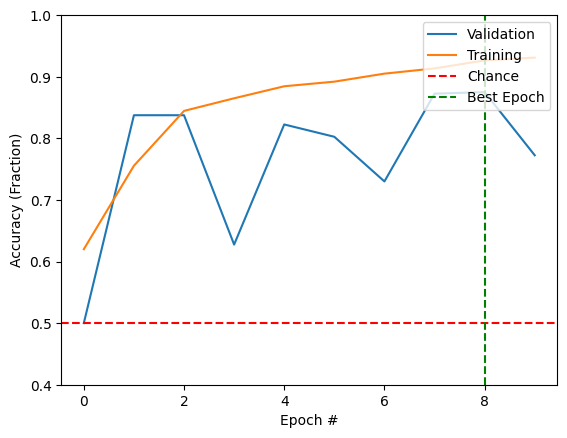

In [15]:
# Model Evaluation - CNN
plot_acc(history_cnn)

In [16]:
# Model Building - Transfer Learning (e.g., VGG16)
transfer_model = TransferClassifier(name='VGG16')
print(model_to_string(transfer_model))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)             (None, 64)                8256      
                                                                 
 dense (Dense)             (None, 1)                 65        
                                                                

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
# Model Training - Transfer Learning (e.g., VGG16)
history_transfer = transfer_model.fit(X_train, y_train, epochs=2, batch_size=64,
                                      validation_data=(X_val, y_val), callbacks=[monitor])


Epoch 1/2


 1/32 [..............................] - ETA: 7:28 - loss: 0.7943 - accuracy: 0.4531

 2/32 [>.............................] - ETA: 6:27 - loss: 0.7878 - accuracy: 0.4453

 3/32 [=>............................] - ETA: 6:13 - loss: 0.7926 - accuracy: 0.4323

 4/32 [==>...........................] - ETA: 5:59 - loss: 0.7663 - accuracy: 0.4609

 5/32 [===>..........................] - ETA: 5:46 - loss: 0.7611 - accuracy: 0.4750

 6/32 [====>.........................] - ETA: 5:32 - loss: 0.7493 - accuracy: 0.4870

 7/32 [=====>........................] - ETA: 5:19 - loss: 0.7481 - accuracy: 0.4933

 8/32 [======>.......................] - ETA: 5:05 - loss: 0.7432 - accuracy: 0.5000

 9/32 [=======>......................] - ETA: 4:52 - loss: 0.7456 - accuracy: 0.4948

10/32 [========>.....................] - ETA: 4:39 - loss: 0.7442 - accuracy: 0.4891

11/32 [=========>....................] - ETA: 4:26 - loss: 0.7383 - accuracy: 0.5014

12/32 [==========>...................] - ETA: 4:14 - loss: 0.7363 - accuracy: 0.5013

13/32 [===========>..................] - ETA: 4:01 - loss: 0.7309 - accuracy: 0.5096

14/32 [============>.................] - ETA: 3:48 - loss: 0.7285 - accuracy: 0.5089

15/32 [=============>................] - ETA: 3:35 - loss: 0.7250 - accuracy: 0.5115

16/32 [==============>...............] - ETA: 3:23 - loss: 0.7223 - accuracy: 0.5117

17/32 [==============>...............] - ETA: 3:10 - loss: 0.7179 - accuracy: 0.5193

18/32 [===============>..............] - ETA: 2:57 - loss: 0.7168 - accuracy: 0.5148

19/32 [================>.............] - ETA: 2:44 - loss: 0.7122 - accuracy: 0.5222

20/32 [=================>............] - ETA: 2:33 - loss: 0.7091 - accuracy: 0.5297

21/32 [==================>...........] - ETA: 2:20 - loss: 0.7062 - accuracy: 0.5327

22/32 [===================>..........] - ETA: 2:07 - loss: 0.7043 - accuracy: 0.5341

23/32 [====================>.........] - ETA: 1:54 - loss: 0.7006 - accuracy: 0.5408

24/32 [=====================>........] - ETA: 1:41 - loss: 0.6984 - accuracy: 0.5443

25/32 [======================>.......] - ETA: 1:29 - loss: 0.6972 - accuracy: 0.5462

26/32 [=======================>......] - ETA: 1:16 - loss: 0.6948 - accuracy: 0.5511

27/32 [========================>.....] - ETA: 1:03 - loss: 0.6926 - accuracy: 0.5532

28/32 [=========================>....] - ETA: 50s - loss: 0.6907 - accuracy: 0.5530 

29/32 [==========================>...] - ETA: 38s - loss: 0.6886 - accuracy: 0.5582

30/32 [===========================>..] - ETA: 25s - loss: 0.6864 - accuracy: 0.5620

31/32 [============================>.] - ETA: 12s - loss: 0.6833 - accuracy: 0.5675

32/32 [==============================] - 423s 13s/step - loss: 0.6823 - accuracy: 0.5680 - val_loss: 0.5971 - val_accuracy: 0.8025
Epoch 2/2


 1/32 [..............................] - ETA: 6:24 - loss: 0.6013 - accuracy: 0.7188

 2/32 [>.............................] - ETA: 6:10 - loss: 0.6129 - accuracy: 0.7188

 3/32 [=>............................] - ETA: 6:02 - loss: 0.5923 - accuracy: 0.7448

 4/32 [==>...........................] - ETA: 5:52 - loss: 0.5917 - accuracy: 0.7383

 5/32 [===>..........................] - ETA: 5:42 - loss: 0.5868 - accuracy: 0.7531

 6/32 [====>.........................] - ETA: 5:30 - loss: 0.5788 - accuracy: 0.7708

 7/32 [=====>........................] - ETA: 5:17 - loss: 0.5775 - accuracy: 0.7679

 8/32 [======>.......................] - ETA: 5:05 - loss: 0.5789 - accuracy: 0.7578

 9/32 [=======>......................] - ETA: 4:52 - loss: 0.5732 - accuracy: 0.7743

10/32 [========>.....................] - ETA: 4:39 - loss: 0.5735 - accuracy: 0.7688

11/32 [=========>....................] - ETA: 4:26 - loss: 0.5695 - accuracy: 0.7770

12/32 [==========>...................] - ETA: 4:16 - loss: 0.5637 - accuracy: 0.7839

13/32 [===========>..................] - ETA: 4:03 - loss: 0.5646 - accuracy: 0.7776

14/32 [============>.................] - ETA: 3:50 - loss: 0.5622 - accuracy: 0.7790

15/32 [=============>................] - ETA: 3:37 - loss: 0.5581 - accuracy: 0.7802

16/32 [==============>...............] - ETA: 3:24 - loss: 0.5518 - accuracy: 0.7891

17/32 [==============>...............] - ETA: 3:11 - loss: 0.5495 - accuracy: 0.7923

18/32 [===============>..............] - ETA: 2:58 - loss: 0.5421 - accuracy: 0.7986

19/32 [================>.............] - ETA: 2:46 - loss: 0.5388 - accuracy: 0.7993

20/32 [=================>............] - ETA: 2:33 - loss: 0.5371 - accuracy: 0.7992

21/32 [==================>...........] - ETA: 2:20 - loss: 0.5331 - accuracy: 0.8013

22/32 [===================>..........] - ETA: 2:07 - loss: 0.5300 - accuracy: 0.8040

23/32 [====================>.........] - ETA: 1:54 - loss: 0.5265 - accuracy: 0.8077

24/32 [=====================>........] - ETA: 1:42 - loss: 0.5216 - accuracy: 0.8125

25/32 [======================>.......] - ETA: 1:29 - loss: 0.5166 - accuracy: 0.8156

26/32 [=======================>......] - ETA: 1:16 - loss: 0.5140 - accuracy: 0.8179

27/32 [========================>.....] - ETA: 1:03 - loss: 0.5083 - accuracy: 0.8218

28/32 [=========================>....] - ETA: 51s - loss: 0.5033 - accuracy: 0.8253 

29/32 [==========================>...] - ETA: 38s - loss: 0.4985 - accuracy: 0.8281

30/32 [===========================>..] - ETA: 25s - loss: 0.4956 - accuracy: 0.8302

31/32 [============================>.] - ETA: 12s - loss: 0.4921 - accuracy: 0.8317

32/32 [==============================] - 419s 13s/step - loss: 0.4911 - accuracy: 0.8315 - val_loss: 0.4152 - val_accuracy: 0.8525


In [18]:
# Save the trained model to a file
transfer_model.save('model.h5')

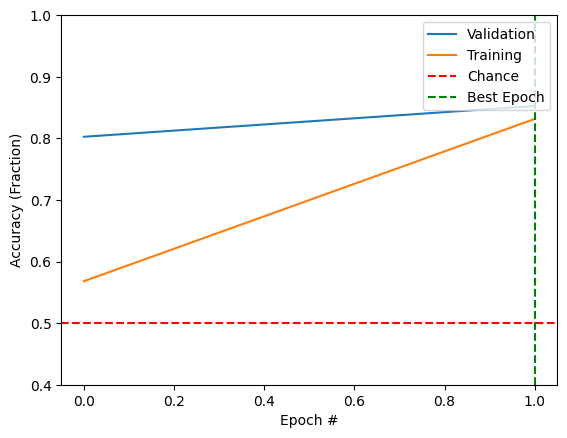

In [19]:
# Model Evaluation - Transfer Learning
plot_acc(history_transfer)

In [20]:
# Model Training - Toy Neural Network
history_toy_nn = toy_nn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[monitor])


Epoch 1/10


 1/63 [..............................] - ETA: 1s - loss: 0.3102 - accuracy: 0.8750

 5/63 [=>............................] - ETA: 0s - loss: 0.3450 - accuracy: 0.8625

 8/63 [==>...........................] - ETA: 0s - loss: 0.3055 - accuracy: 0.8828

12/63 [====>.........................] - ETA: 0s - loss: 0.2887 - accuracy: 0.8932

16/63 [======>.......................] - ETA: 0s - loss: 0.2852 - accuracy: 0.9004

20/63 [========>.....................] - ETA: 0s - loss: 0.2742 - accuracy: 0.9094

24/63 [==========>...................] - ETA: 0s - loss: 0.2714 - accuracy: 0.9154

28/63 [============>.................] - ETA: 0s - loss: 0.2693 - accuracy: 0.9107

32/63 [==============>...............] - ETA: 0s - loss: 0.2674 - accuracy: 0.9072

36/63 [================>.............] - ETA: 0s - loss: 0.2653 - accuracy: 0.9089

39/63 [=================>............] - ETA: 0s - loss: 0.2678 - accuracy: 0.9119

42/63 [===================>..........] - ETA: 0s - loss: 0.2700 - accuracy: 0.9100

45/63 [====================>.........] - ETA: 0s - loss: 0.2713 - accuracy: 0.9062

48/63 [=====================>........] - ETA: 0s - loss: 0.2725 - accuracy: 0.9023

51/63 [=======================>......] - ETA: 0s - loss: 0.2716 - accuracy: 0.9026

54/63 [========================>.....] - ETA: 0s - loss: 0.2718 - accuracy: 0.9016

57/63 [==========================>...] - ETA: 0s - loss: 0.2696 - accuracy: 0.9035

60/63 [===========================>..] - ETA: 0s - loss: 0.2666 - accuracy: 0.9057

63/63 [==============================] - 1s 21ms/step - loss: 0.2659 - accuracy: 0.9045 - val_loss: 0.4337 - val_accuracy: 0.7800
Epoch 2/10


 1/63 [..............................] - ETA: 1s - loss: 0.1920 - accuracy: 0.8750

 4/63 [>.............................] - ETA: 1s - loss: 0.2326 - accuracy: 0.8984

 7/63 [==>...........................] - ETA: 1s - loss: 0.2387 - accuracy: 0.8973

10/63 [===>..........................] - ETA: 1s - loss: 0.2239 - accuracy: 0.9156

13/63 [=====>........................] - ETA: 1s - loss: 0.2378 - accuracy: 0.9038

16/63 [======>.......................] - ETA: 0s - loss: 0.2363 - accuracy: 0.9082

19/63 [========>.....................] - ETA: 0s - loss: 0.2396 - accuracy: 0.9128

22/63 [=========>....................] - ETA: 0s - loss: 0.2530 - accuracy: 0.9062

25/63 [==========>...................] - ETA: 0s - loss: 0.2554 - accuracy: 0.9025

28/63 [============>.................] - ETA: 0s - loss: 0.2555 - accuracy: 0.9051

31/63 [=============>................] - ETA: 0s - loss: 0.2593 - accuracy: 0.9032

34/63 [===============>..............] - ETA: 0s - loss: 0.2565 - accuracy: 0.9062

37/63 [================>.............] - ETA: 0s - loss: 0.2617 - accuracy: 0.9046

40/63 [==================>...........] - ETA: 0s - loss: 0.2610 - accuracy: 0.9047

43/63 [===================>..........] - ETA: 0s - loss: 0.2591 - accuracy: 0.9062

46/63 [====================>.........] - ETA: 0s - loss: 0.2605 - accuracy: 0.9076

49/63 [======================>.......] - ETA: 0s - loss: 0.2618 - accuracy: 0.9082

52/63 [=======================>......] - ETA: 0s - loss: 0.2567 - accuracy: 0.9111

55/63 [=========================>....] - ETA: 0s - loss: 0.2568 - accuracy: 0.9131

58/63 [==========================>...] - ETA: 0s - loss: 0.2555 - accuracy: 0.9127

61/63 [============================>.] - ETA: 0s - loss: 0.2573 - accuracy: 0.9124

63/63 [==============================] - 1s 24ms/step - loss: 0.2566 - accuracy: 0.9130 - val_loss: 0.4008 - val_accuracy: 0.7925
Epoch 3/10


 1/63 [..............................] - ETA: 1s - loss: 0.2158 - accuracy: 0.9062

 4/63 [>.............................] - ETA: 1s - loss: 0.2254 - accuracy: 0.9297

 7/63 [==>...........................] - ETA: 1s - loss: 0.2419 - accuracy: 0.9062

10/63 [===>..........................] - ETA: 1s - loss: 0.2504 - accuracy: 0.9156

13/63 [=====>........................] - ETA: 1s - loss: 0.2462 - accuracy: 0.9159

16/63 [======>.......................] - ETA: 0s - loss: 0.2457 - accuracy: 0.9160

19/63 [========>.....................] - ETA: 0s - loss: 0.2526 - accuracy: 0.9128

21/63 [=========>....................] - ETA: 0s - loss: 0.2539 - accuracy: 0.9077

24/63 [==========>...................] - ETA: 0s - loss: 0.2497 - accuracy: 0.9062

27/63 [===========>..................] - ETA: 0s - loss: 0.2486 - accuracy: 0.9051

30/63 [=============>................] - ETA: 0s - loss: 0.2446 - accuracy: 0.9062

33/63 [==============>...............] - ETA: 0s - loss: 0.2479 - accuracy: 0.9053

36/63 [================>.............] - ETA: 0s - loss: 0.2471 - accuracy: 0.9080

39/63 [=================>............] - ETA: 0s - loss: 0.2459 - accuracy: 0.9087

42/63 [===================>..........] - ETA: 0s - loss: 0.2476 - accuracy: 0.9077

45/63 [====================>.........] - ETA: 0s - loss: 0.2523 - accuracy: 0.9049

48/63 [=====================>........] - ETA: 0s - loss: 0.2513 - accuracy: 0.9069

51/63 [=======================>......] - ETA: 0s - loss: 0.2505 - accuracy: 0.9087

54/63 [========================>.....] - ETA: 0s - loss: 0.2476 - accuracy: 0.9097

57/63 [==========================>...] - ETA: 0s - loss: 0.2444 - accuracy: 0.9123

60/63 [===========================>..] - ETA: 0s - loss: 0.2456 - accuracy: 0.9109

63/63 [==============================] - 2s 25ms/step - loss: 0.2431 - accuracy: 0.9130 - val_loss: 0.4215 - val_accuracy: 0.7725
Epoch 4/10


 1/63 [..............................] - ETA: 1s - loss: 0.3344 - accuracy: 0.9062

 4/63 [>.............................] - ETA: 1s - loss: 0.3089 - accuracy: 0.8906

 7/63 [==>...........................] - ETA: 0s - loss: 0.2897 - accuracy: 0.8973

10/63 [===>..........................] - ETA: 0s - loss: 0.2625 - accuracy: 0.9094

14/63 [=====>........................] - ETA: 0s - loss: 0.2810 - accuracy: 0.8906

17/63 [=======>......................] - ETA: 0s - loss: 0.2795 - accuracy: 0.8897

20/63 [========>.....................] - ETA: 0s - loss: 0.2699 - accuracy: 0.8984

23/63 [=========>....................] - ETA: 0s - loss: 0.2628 - accuracy: 0.9022

26/63 [===========>..................] - ETA: 0s - loss: 0.2535 - accuracy: 0.9075

29/63 [============>.................] - ETA: 0s - loss: 0.2606 - accuracy: 0.9073

32/63 [==============>...............] - ETA: 0s - loss: 0.2501 - accuracy: 0.9121

35/63 [===============>..............] - ETA: 0s - loss: 0.2462 - accuracy: 0.9125

38/63 [=================>............] - ETA: 0s - loss: 0.2476 - accuracy: 0.9128

41/63 [==================>...........] - ETA: 0s - loss: 0.2480 - accuracy: 0.9101

44/63 [===================>..........] - ETA: 0s - loss: 0.2455 - accuracy: 0.9126

47/63 [=====================>........] - ETA: 0s - loss: 0.2420 - accuracy: 0.9156

50/63 [======================>.......] - ETA: 0s - loss: 0.2397 - accuracy: 0.9169

53/63 [========================>.....] - ETA: 0s - loss: 0.2403 - accuracy: 0.9175

57/63 [==========================>...] - ETA: 0s - loss: 0.2401 - accuracy: 0.9161

61/63 [============================>.] - ETA: 0s - loss: 0.2410 - accuracy: 0.9160

63/63 [==============================] - 1s 19ms/step - loss: 0.2403 - accuracy: 0.9170 - val_loss: 0.4729 - val_accuracy: 0.7525
Epoch 5/10


 1/63 [..............................] - ETA: 1s - loss: 0.1911 - accuracy: 0.9375

 4/63 [>.............................] - ETA: 1s - loss: 0.2260 - accuracy: 0.9219

 7/63 [==>...........................] - ETA: 1s - loss: 0.2561 - accuracy: 0.9018

10/63 [===>..........................] - ETA: 0s - loss: 0.2443 - accuracy: 0.9125

13/63 [=====>........................] - ETA: 0s - loss: 0.2396 - accuracy: 0.9159

16/63 [======>.......................] - ETA: 0s - loss: 0.2587 - accuracy: 0.9121

20/63 [========>.....................] - ETA: 0s - loss: 0.2513 - accuracy: 0.9125

24/63 [==========>...................] - ETA: 0s - loss: 0.2493 - accuracy: 0.9115

28/63 [============>.................] - ETA: 0s - loss: 0.2544 - accuracy: 0.9085

31/63 [=============>................] - ETA: 0s - loss: 0.2515 - accuracy: 0.9093

34/63 [===============>..............] - ETA: 0s - loss: 0.2483 - accuracy: 0.9081

37/63 [================>.............] - ETA: 0s - loss: 0.2444 - accuracy: 0.9088

40/63 [==================>...........] - ETA: 0s - loss: 0.2463 - accuracy: 0.9070

43/63 [===================>..........] - ETA: 0s - loss: 0.2433 - accuracy: 0.9077

46/63 [====================>.........] - ETA: 0s - loss: 0.2381 - accuracy: 0.9103

49/63 [======================>.......] - ETA: 0s - loss: 0.2390 - accuracy: 0.9101

53/63 [========================>.....] - ETA: 0s - loss: 0.2366 - accuracy: 0.9116

56/63 [=========================>....] - ETA: 0s - loss: 0.2340 - accuracy: 0.9141

60/63 [===========================>..] - ETA: 0s - loss: 0.2362 - accuracy: 0.9135

63/63 [==============================] - 1s 19ms/step - loss: 0.2344 - accuracy: 0.9145 - val_loss: 0.4956 - val_accuracy: 0.7400
Epoch 6/10


 1/63 [..............................] - ETA: 1s - loss: 0.4244 - accuracy: 0.8125

 4/63 [>.............................] - ETA: 1s - loss: 0.2939 - accuracy: 0.8984

 7/63 [==>...........................] - ETA: 1s - loss: 0.2450 - accuracy: 0.9107

11/63 [====>.........................] - ETA: 0s - loss: 0.2316 - accuracy: 0.9290

14/63 [=====>........................] - ETA: 0s - loss: 0.2234 - accuracy: 0.9330

17/63 [=======>......................] - ETA: 0s - loss: 0.2326 - accuracy: 0.9265

20/63 [========>.....................] - ETA: 0s - loss: 0.2276 - accuracy: 0.9312

23/63 [=========>....................] - ETA: 0s - loss: 0.2369 - accuracy: 0.9280

27/63 [===========>..................] - ETA: 0s - loss: 0.2322 - accuracy: 0.9282

31/63 [=============>................] - ETA: 0s - loss: 0.2312 - accuracy: 0.9274

34/63 [===============>..............] - ETA: 0s - loss: 0.2252 - accuracy: 0.9320

37/63 [================>.............] - ETA: 0s - loss: 0.2269 - accuracy: 0.9299

40/63 [==================>...........] - ETA: 0s - loss: 0.2287 - accuracy: 0.9258

43/63 [===================>..........] - ETA: 0s - loss: 0.2283 - accuracy: 0.9244

46/63 [====================>.........] - ETA: 0s - loss: 0.2287 - accuracy: 0.9219

49/63 [======================>.......] - ETA: 0s - loss: 0.2273 - accuracy: 0.9216

52/63 [=======================>......] - ETA: 0s - loss: 0.2222 - accuracy: 0.9249

54/63 [========================>.....] - ETA: 0s - loss: 0.2227 - accuracy: 0.9259

57/63 [==========================>...] - ETA: 0s - loss: 0.2222 - accuracy: 0.9265

60/63 [===========================>..] - ETA: 0s - loss: 0.2221 - accuracy: 0.9276

63/63 [==============================] - 1s 22ms/step - loss: 0.2230 - accuracy: 0.9265 - val_loss: 0.5171 - val_accuracy: 0.7325
Epoch 7/10


 1/63 [..............................] - ETA: 1s - loss: 0.2091 - accuracy: 0.9062

 4/63 [>.............................] - ETA: 1s - loss: 0.2148 - accuracy: 0.8984

 7/63 [==>...........................] - ETA: 1s - loss: 0.1807 - accuracy: 0.9286

10/63 [===>..........................] - ETA: 1s - loss: 0.1988 - accuracy: 0.9219

12/63 [====>.........................] - ETA: 1s - loss: 0.2092 - accuracy: 0.9141

15/63 [======>.......................] - ETA: 1s - loss: 0.2188 - accuracy: 0.9104

18/63 [=======>......................] - ETA: 0s - loss: 0.2148 - accuracy: 0.9149

21/63 [=========>....................] - ETA: 0s - loss: 0.2200 - accuracy: 0.9167

24/63 [==========>...................] - ETA: 0s - loss: 0.2233 - accuracy: 0.9128

27/63 [===========>..................] - ETA: 0s - loss: 0.2202 - accuracy: 0.9178

30/63 [=============>................] - ETA: 0s - loss: 0.2163 - accuracy: 0.9219

33/63 [==============>...............] - ETA: 0s - loss: 0.2168 - accuracy: 0.9214

36/63 [================>.............] - ETA: 0s - loss: 0.2190 - accuracy: 0.9193

39/63 [=================>............] - ETA: 0s - loss: 0.2179 - accuracy: 0.9207

42/63 [===================>..........] - ETA: 0s - loss: 0.2152 - accuracy: 0.9219

45/63 [====================>.........] - ETA: 0s - loss: 0.2114 - accuracy: 0.9243

48/63 [=====================>........] - ETA: 0s - loss: 0.2133 - accuracy: 0.9251

51/63 [=======================>......] - ETA: 0s - loss: 0.2140 - accuracy: 0.9252

54/63 [========================>.....] - ETA: 0s - loss: 0.2167 - accuracy: 0.9248

57/63 [==========================>...] - ETA: 0s - loss: 0.2126 - accuracy: 0.9265

60/63 [===========================>..] - ETA: 0s - loss: 0.2137 - accuracy: 0.9255

63/63 [==============================] - 1s 23ms/step - loss: 0.2132 - accuracy: 0.9255 - val_loss: 0.4532 - val_accuracy: 0.7475
Epoch 8/10


 1/63 [..............................] - ETA: 1s - loss: 0.2860 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 1s - loss: 0.3112 - accuracy: 0.8958

 6/63 [=>............................] - ETA: 1s - loss: 0.2742 - accuracy: 0.9167

 9/63 [===>..........................] - ETA: 1s - loss: 0.2544 - accuracy: 0.9271

12/63 [====>.........................] - ETA: 1s - loss: 0.2386 - accuracy: 0.9271

15/63 [======>.......................] - ETA: 1s - loss: 0.2328 - accuracy: 0.9271

17/63 [=======>......................] - ETA: 1s - loss: 0.2188 - accuracy: 0.9301

19/63 [========>.....................] - ETA: 1s - loss: 0.2200 - accuracy: 0.9276

21/63 [=========>....................] - ETA: 1s - loss: 0.2278 - accuracy: 0.9182

24/63 [==========>...................] - ETA: 0s - loss: 0.2187 - accuracy: 0.9245

27/63 [===========>..................] - ETA: 0s - loss: 0.2226 - accuracy: 0.9201

30/63 [=============>................] - ETA: 0s - loss: 0.2222 - accuracy: 0.9208

33/63 [==============>...............] - ETA: 0s - loss: 0.2224 - accuracy: 0.9195

36/63 [================>.............] - ETA: 0s - loss: 0.2215 - accuracy: 0.9201

39/63 [=================>............] - ETA: 0s - loss: 0.2305 - accuracy: 0.9127

42/63 [===================>..........] - ETA: 0s - loss: 0.2290 - accuracy: 0.9144

45/63 [====================>.........] - ETA: 0s - loss: 0.2259 - accuracy: 0.9174

48/63 [=====================>........] - ETA: 0s - loss: 0.2207 - accuracy: 0.9206

51/63 [=======================>......] - ETA: 0s - loss: 0.2206 - accuracy: 0.9197

53/63 [========================>.....] - ETA: 0s - loss: 0.2170 - accuracy: 0.9222

56/63 [=========================>....] - ETA: 0s - loss: 0.2146 - accuracy: 0.9230

59/63 [===========================>..] - ETA: 0s - loss: 0.2164 - accuracy: 0.9221

62/63 [============================>.] - ETA: 0s - loss: 0.2126 - accuracy: 0.9244

63/63 [==============================] - 2s 27ms/step - loss: 0.2123 - accuracy: 0.9245 - val_loss: 0.5110 - val_accuracy: 0.7400
Epoch 9/10


 1/63 [..............................] - ETA: 1s - loss: 0.1546 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 1s - loss: 0.1613 - accuracy: 0.9583

 6/63 [=>............................] - ETA: 1s - loss: 0.1949 - accuracy: 0.9271

 9/63 [===>..........................] - ETA: 1s - loss: 0.1780 - accuracy: 0.9375

12/63 [====>.........................] - ETA: 1s - loss: 0.2002 - accuracy: 0.9245

14/63 [=====>........................] - ETA: 1s - loss: 0.1943 - accuracy: 0.9286

16/63 [======>.......................] - ETA: 1s - loss: 0.1862 - accuracy: 0.9336

19/63 [========>.....................] - ETA: 0s - loss: 0.1976 - accuracy: 0.9309

22/63 [=========>....................] - ETA: 0s - loss: 0.1907 - accuracy: 0.9347

25/63 [==========>...................] - ETA: 0s - loss: 0.1979 - accuracy: 0.9275

28/63 [============>.................] - ETA: 0s - loss: 0.2009 - accuracy: 0.9263

31/63 [=============>................] - ETA: 0s - loss: 0.1999 - accuracy: 0.9284

34/63 [===============>..............] - ETA: 0s - loss: 0.2027 - accuracy: 0.9256

37/63 [================>.............] - ETA: 0s - loss: 0.2000 - accuracy: 0.9265

40/63 [==================>...........] - ETA: 0s - loss: 0.1977 - accuracy: 0.9281

43/63 [===================>..........] - ETA: 0s - loss: 0.1949 - accuracy: 0.9288

46/63 [====================>.........] - ETA: 0s - loss: 0.1996 - accuracy: 0.9273

49/63 [======================>.......] - ETA: 0s - loss: 0.2042 - accuracy: 0.9260

52/63 [=======================>......] - ETA: 0s - loss: 0.2013 - accuracy: 0.9285

54/63 [========================>.....] - ETA: 0s - loss: 0.1998 - accuracy: 0.9288

56/63 [=========================>....] - ETA: 0s - loss: 0.1997 - accuracy: 0.9302

59/63 [===========================>..] - ETA: 0s - loss: 0.1999 - accuracy: 0.9280

61/63 [============================>.] - ETA: 0s - loss: 0.2002 - accuracy: 0.9278

63/63 [==============================] - 1s 24ms/step - loss: 0.1998 - accuracy: 0.9280 - val_loss: 0.5833 - val_accuracy: 0.7200
Epoch 10/10


 1/63 [..............................] - ETA: 1s - loss: 0.1151 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.1431 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 1s - loss: 0.1716 - accuracy: 0.9330

10/63 [===>..........................] - ETA: 1s - loss: 0.1844 - accuracy: 0.9250

14/63 [=====>........................] - ETA: 0s - loss: 0.1962 - accuracy: 0.9219

17/63 [=======>......................] - ETA: 0s - loss: 0.2062 - accuracy: 0.9154

20/63 [========>.....................] - ETA: 0s - loss: 0.2082 - accuracy: 0.9141

23/63 [=========>....................] - ETA: 0s - loss: 0.2041 - accuracy: 0.9198

26/63 [===========>..................] - ETA: 0s - loss: 0.1995 - accuracy: 0.9243

29/63 [============>.................] - ETA: 0s - loss: 0.2037 - accuracy: 0.9235

32/63 [==============>...............] - ETA: 0s - loss: 0.2080 - accuracy: 0.9229

35/63 [===============>..............] - ETA: 0s - loss: 0.2135 - accuracy: 0.9232

38/63 [=================>............] - ETA: 0s - loss: 0.2145 - accuracy: 0.9219

41/63 [==================>...........] - ETA: 0s - loss: 0.2082 - accuracy: 0.9261

44/63 [===================>..........] - ETA: 0s - loss: 0.2072 - accuracy: 0.9254

47/63 [=====================>........] - ETA: 0s - loss: 0.2063 - accuracy: 0.9262

50/63 [======================>.......] - ETA: 0s - loss: 0.2088 - accuracy: 0.9244

53/63 [========================>.....] - ETA: 0s - loss: 0.2112 - accuracy: 0.9216

56/63 [=========================>....] - ETA: 0s - loss: 0.2124 - accuracy: 0.9213

59/63 [===========================>..] - ETA: 0s - loss: 0.2133 - accuracy: 0.9195

62/63 [============================>.] - ETA: 0s - loss: 0.2161 - accuracy: 0.9178

63/63 [==============================] - 1s 21ms/step - loss: 0.2158 - accuracy: 0.9180 - val_loss: 0.7146 - val_accuracy: 0.6750


# Load the best-performing model and Making Predictions

13/13 [==============================] - 19s 1s/step
              precision    recall  f1-score   support

         0.0       0.90      0.80      0.84       200
         1.0       0.82      0.91      0.86       200

    accuracy                           0.85       400
   macro avg       0.86      0.85      0.85       400
weighted avg       0.86      0.85      0.85       400



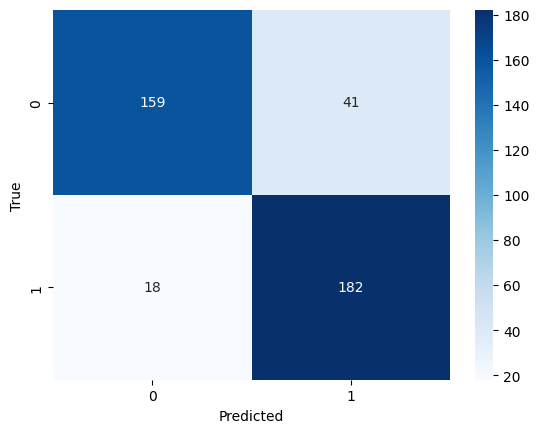

In [21]:
# Load the best-performing model
best_model = keras.models.load_model('./model.h5')

# Make predictions on the test set
X_test, y_test = get_test_data(flatten=False)
y_pred = best_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Classification Report and Confusion Matrix
print(classification_report(y_test, y_pred_binary))
conf_matrix = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
